# Stock Market Prediction: Modeling

In this series of notebooks, I will create a machine learning algorithm to predict the stock price (Adjusted Close) and make a trading recommendation for the user. 

The input features are:
- Open 
- Close
- Low
- High

For the following stocks, I will create a trained algorithm:
- *Blue chip stocks*: Blue chip stocks are shares of large, established companies with stable financial performance and low risk.
    - BMW (BMW.DE)
    <p>&nbsp;</p> 
- *Growth stocks*: growth stocks are stocks of companies with high potential for future growth. These stocks often carry higher risks, but also offer higher potential returns
    - Tesla, Inc. (TSLA)
    - Bitcoin (BTC-USD)
    <p>&nbsp;</p>
- *Dividend stocks*: dividend stocks are stocks of companies that pay regular dividends to their shareholders. These stocks often carry lower risks and offer a regular source of income. 
    - Johnson & Johnson (JNJ)
    <p>&nbsp;</p>
- *Small-cap stocks*: small-cap stocks are stocks of small companies with higher risk and higher potential for growth and return.
     - Etsy, Inc (ETSY)

The following algorithm will be used for prediction:
- LSTM (Long Short-Term Memory)

This is a popular algorithms for stock prediction. 

The goal is to create an algorithm which can predict the stock prices with a tolerance of ± 5%.
Also, I want to show how the different stock categories influence the accuracy of the algorithm. 

The final program on Github.com (https://github.com/maximkiesel1/Stock_Market_Prediction)  can be used for all stocks.

In this notebook, the focus will be to do feature engineering, splitting the data, train the models and validate the performance. 

## Table Of Contents 

#### 1. [Feature Engineering](#fe)  
#### 2. [LSTM](#lstm)

In [505]:
# load libraries
import sys

from sqlalchemy import create_engine, text, inspect
import ssl

import pandas as pd
import numpy as np

import ta

from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor
import pickle

import absl.logging
import logging

import random

## <a class="anchor" id="fe"> 1. Feature Engineering </a>

At first, I load the data from a database. After that, I define the new features and integrate them. Lastly, I split the data in training, validation, and test data. Also, the data will be transformed in a fitted form for the LSTM algorithm.

In [2]:
def load_data(database_filepath):
    '''
    Loading the data from a sql database and transform it to X, y data for the machine learning model.
    
    INPUT 
    database_filepath - (str) path to the sql database
      
    OUTPUT
    Xs - (dict) Features dfs for the stocks
    ys - (dict) Target variables for the stocks
    '''
    # create the engine for the sql database
    engine = create_engine(f'sqlite:///{database_filepath}')
    
    # create a connection
    conn = engine.connect()
    
    # find the table names in the db
    inspector = inspect(engine)
    table_names = inspector.get_table_names()
    
    dfs = {}
    for name in table_names:
        
        # transform to a executable object for pandas
        sql = text("SELECT * FROM '{}'".format(name))
        
        # create the dataframe
        df = pd.read_sql(sql, conn)

        # remove hours, minutes, and seconds from the date
        df['date'] = pd.to_datetime(df['date']).dt.date
        
        # set the date as index
        df = df.set_index('date')
        
        dfs[name] = df
        
    return dfs

In [3]:
dfs = load_data('/Users/maximkiesel/PycharmProjects/Stock_Market_Prediction/data/cleaned_data.db')

I will know explain the new features:

- *Moving Averages (SMA, EMA)*: A moving average calculates the average price of a security or other asset over a specified period of time. The Simple Moving Average (SMA) is the average price over the specified time period. Exponential Moving Average (EMA) is a type of moving average that places more emphasis on the most recent data.
<p>&nbsp;</p>
- *Bollinger Bands*: Bollinger Bands are an indicator of the volatility of securities or other assets. They consist of three lines: a simple moving average line, an upper band line, and a lower band line that are two standard deviations away from the simple moving average.
<p>&nbsp;</p>
- *Average True Range (ATR)*: The Average True Range is a measure of the volatility of a security or other asset. It is the average of the largest daily price movements of a security or asset over a given time period.
<p>&nbsp;</p>
- *MACD*: Moving Average Convergence Divergence (MACD) is an indicator of the trend and momentum changes of a security or other asset. It is calculated by subtracting the 26-period EMA from the 12-period EMA.
<p>&nbsp;</p>
- *RSI*: The Relative Strength Index (RSI) is an indicator of the strength of a trend and potential trend reversal. It is calculated by computing the ratio of average gains and losses over a given period of time.
<p>&nbsp;</p>
- *Stochastic Oscillator*: The Stochastic Oscillator is a momentum indicator that helps identify overbought and oversold conditions. It compares the closing price of a security or other asset to the high-low range over a specified time period.
<p>&nbsp;</p>
- *Stochastic signal*: The Stochastic signal is a signal or trigger line calculated from the moving average of the Stochastic oscillator. It is used to generate buy and sell signals when it crosses above or below the oscillator.

In [549]:
def feat_eng(dfs):
    '''
    Create new features for the X dfs and clean potential Nan values.
    Adjusted the amount of y values.
    
    INPUT 
    Xs - (dict) Feature dfs of the stocks
    ys - (dict) Target variables of the stocks
      
    OUTPUT
    Xs_nor - (dict) cleaned, extended and normalized X dfs
    ys_nor - (dict) cleaned and normalized y dfs for the target variable
    Xs_1 - (dict) cleaned and extended X dfs
    ys_1 - (dict) cleaned y dfs for the target variable
    '''
    
    # create empty dict for the new dfs with the new features
    dfs_feat= {}
    dfs_nor= {}
    
    for name in dfs:
        
        # define the dfs from the dict
        df = dfs[name]

        # Moving Averages (SMA, EMA)
        df['SMA'] = ta.trend.sma_indicator(df['Adj Close'], window=20)
        df['EMA'] = ta.trend.ema_indicator(df['Adj Close'], window=20)

        # Bollinger Bands
        bb = ta.volatility.BollingerBands(close=df['Adj Close'], window=20, window_dev=2)
        df['BB_High'] = bb.bollinger_hband()
        df['BB_Low'] = bb.bollinger_lband()

        # Average True Range (ATR)
        atr = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close= df['Adj Close'], window=14)
        df['ATR'] = atr.average_true_range()

        # MACD
        macd = ta.trend.MACD(df['Adj Close'], window_slow=26, window_fast=12, window_sign=9)
        df['MACD'] = macd.macd()
        df['MACD_Signal'] = macd.macd_signal()
        df['MACD_Diff'] = macd.macd_diff()

        # RSI
        df['RSI'] = ta.momentum.RSIIndicator(df['Adj Close'], window=14).rsi()

        # Stochastic Oscillator
        stoch = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Adj Close'], window=14, smooth_window=3)
        df['Stoch_Oscillator'] = stoch.stoch()
        df['Stoch_Signal'] = stoch.stoch_signal()
        
        # delete all row with no values (because of the new features)
        # find the max rows with nan values
        max_nan_row = max(df.isna().sum())
        df = df.drop(df.index[:max_nan_row])
        
        # put the target variable on the place of the last column to find it later
        col_name = 'Adj Close'
        col_to_move = df.pop(col_name)
        df.insert(len(df.columns), col_name, col_to_move)
        
        # add the df in the dict
        dfs_feat[name] = df

        
        
    return dfs_feat

In [550]:
# call the function
dfs_feat = feat_eng(dfs)

In [551]:
def train_test_lstm(dfs_feat, window_size):
    '''
    Splitting of the datasets in the dictionaries in train, validation, and test (60%, 20%, 20%).
    Transform the date that it can used in the lstm algorithm
    
    INPUT 
    Xs_nor - (dict) Cleaned and normalized feature dfs of the stocks 
    ys_nor - (dict) Normalized target variables of the stocks
    windows_size - 
      
    OUTPUT
    Xs_train - (dict) Splits training data of the input features
    Xs_val - (dict) Split validation data of the input features
    Xs_test - (dict) Split test data of the input features
    ys_train - (dict) Split training data of the output feature
    ys_val - (dict) Split validation data of the output feature
    ys_test - (dict) Split test data of the output feature
    '''
    
    # define empty dict 
    Xs_train = {}
    Xs_test = {}
    Xs_val = {}
    ys_train = {}
    ys_val = {}
    ys_test = {}
    
    # iterate through the dict
    for name in dfs_feat:
        
        # select the dfs
        df = dfs_feat[name]
        
        # convert to numpy
        df_np = df.to_numpy()
        
        # create empty lists to fill the data in the appropriated form for lstm
        X, y = [], []
        
        for i in range(len(df_np)-window_size):
            
            # select the first x data points of the input features and append them to the list
            row = [r for r in df_np[i:i+window_size]]
            X.append(row)
            
            # select the x+1 data point of the target variable and append them to the list
            label = df_np[i+window_size]
            y.append(label)
            
        # data splitting
        train_size = int(len(X) * 0.6)
        val_size = train_size + int(len(X) * 0.2)
        X_train, X_val, X_test = np.array(X[:train_size]), np.array(X[train_size:val_size]), np.array(X[val_size:])
        y_train, y_val, y_test = np.array(y[:train_size]), np.array(y[train_size:val_size]), np.array(y[val_size:])
        
        normalized_X_train = (X_train - X_train.mean()) / X_train.std()
        normalized_X_val = (X_val - X_val.mean()) / X_val.std()
        normalized_X_test = (X_test - X_test.mean()) / X_test.std()
        
        normalized_y_train = (y_train - y_train.mean()) / y_train.std()
        normalized_y_val = (y_val - y_val.mean()) / y_val.std()
        normalized_y_test = (y_test - y_test.mean()) / y_test.std()
        
        # insert split data in the dict
        Xs_train[name] = normalized_X_train
        Xs_val[name] = normalized_X_val
        Xs_test[name] = normalized_X_test
        
        ys_train[name] = normalized_y_train
        ys_val[name] = normalized_y_val
        ys_test[name] = normalized_y_test
        
    return Xs_train, Xs_val, Xs_test, ys_train, ys_val, ys_test

In [552]:
# create the datasets
Xs_train, Xs_val, Xs_test, ys_train, ys_val, ys_test = train_test_lstm(dfs_feat, 10)

## <a class="anchor" id="lstm"> 2. LSTM </a>

In [555]:
len(Xs_test['JNJ'])

240

Now I will define a very popular algorithm for time series. It´s the Long Short-Term Memory (LSTM). A Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) architecture that is designed to model sequential data by retaining and selectively forgetting previous information. It achieves this by using a memory cell, an input gate, an output gate, and a forget gate to regulate the flow of information through the cell. 

At first, I define the algorithm for one stock ('JNJ') and see if it can perform the 5% tolerance.

In [544]:
params = {
    'window_size': [4, 8, 12],
    'lstm_units': [32, 64, 128],
    'dense_units': [16, 32, 64],
    'learning_rate': [0.001, 0.01, 0.1]
}

In [ ]:
best_model = {}

for i in range(1,21):
    random_params = {key: random.choice(values) for key, values in params.items()}
    
    Xs_train, Xs_val, Xs_test, ys_train, ys_val, ys_test = train_test_lstm(dfs_feat, random_params['window_size'])
    
    # define the model for the stock JNJ
    model_jnj = Sequential()
    model_jnj.add(InputLayer((random_params['window_size'], 17))) # the first parameter is always the window size, the second the number of features
    model_jnj.add(LSTM(random_params['lstm_units']))
    model_jnj.add(Dense(random_params['dense_units'], 'relu'))
    model_jnj.add(Dense(17, 'linear')) # output of 17 features
    model_jnj.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=random_params['learning_rate']), metrics=[RootMeanSquaredError()], run_eagerly=True)

    model_jnj.summary()
    
    # create a model checkpoint for the best model
    cp_jnj = ModelCheckpoint('model_jnj/', save_best_only=True, verbose=0)
    
    # remove error messages from tensorflow
    absl.logging.set_verbosity(absl.logging.ERROR)
    logging.getLogger('tensorflow').disabled = True
    
    # fitting the model
    history = model_jnj.fit(Xs_train['JNJ'], ys_train['JNJ'], validation_data=(Xs_val['JNJ'], ys_val['JNJ']), epochs=50, callbacks=[cp_jnj], verbose=0)
    
    # load the best model
    model_jnj = load_model('model_jnj/')
    
    tf.data.experimental.enable_debug_mode()
    
    # make predictions on the testing data
    test_predictions = model_jnj.predict(Xs_test['JNJ'])

    # select the Adjusted Close for prediction (last column)
    test_predictions = [arr[-1] for arr in test_predictions]

    # select the Adjusted Close for test data (last column)
    y_test_jnj = [arr[-1] for arr in ys_test['JNJ']]

    # calculate the percent difference between the predictions and ground truth
    diff_test = np.array(test_predictions) - np.array(y_test_jnj)
       
    percent_diff_test = np.mean(np.abs(diff_test / test_predictions) * 100)
            
    # get the best mse from the best model
    best_mse = history.history['val_loss'][np.argmin(history.history['val_loss'])]
            
    # if this is the first window size, set the accuracy to the current percent difference
    if i == 1:
                
        best_model['model'] = model_jnj
        best_model['accuracy'] = percent_diff_test
        best_model['mse'] = best_mse
        best_model['paramter'] = random_params
            
    # otherwise, compare the current accuracy to the previous best accuracy and update if necessary
    else:
                
        if best_models[name]['mse'] > best_mse:
                    
            best_model['model'] = model_jnj
            best_model['accuracy'] = percent_diff_test
            best_model['mse'] = best_mse
            best_model['paramter'] = random_params
                
        else:
                    
            continue
    

Model: "sequential_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_117 (LSTM)             (None, 64)                20992     
                                                                 
 dense_236 (Dense)           (None, 32)                2080      
                                                                 
 dense_237 (Dense)           (None, 17)                561       
                                                                 
Total params: 23,633
Trainable params: 23,633
Non-trainable params: 0
_________________________________________________________________


In [470]:
# define the model for the stock JNJ
model_jnj = Sequential()
model_jnj.add(InputLayer((10, 17))) # the first parameter is always the window size, the second the number of features
model_jnj.add(LSTM(128))
model_jnj.add(Dense(64, 'relu'))
model_jnj.add(Dense(17, 'linear')) # output of 17 features
model_jnj.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

model_jnj.summary()

Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_100 (LSTM)             (None, 128)               74752     
                                                                 
 dense_200 (Dense)           (None, 64)                8256      
                                                                 
 dense_201 (Dense)           (None, 17)                1105      
                                                                 
Total params: 84,113
Trainable params: 84,113
Non-trainable params: 0
_________________________________________________________________


In [471]:
# create a model checkpoint for the best model
cp_jnj = ModelCheckpoint('model_jnj/', save_best_only=True, verbose=0)

In [472]:
# remove error messages from tensorflow
absl.logging.set_verbosity(absl.logging.ERROR)
logging.getLogger('tensorflow').disabled = True

In [473]:
# fitting the model
history = model_jnj.fit(np.array(Xs_train['JNJ']), np.array(ys_train['JNJ']), validation_data=(np.array(Xs_val['JNJ']), np.array(ys_val['JNJ'])), epochs=50, callbacks=[cp_jnj], verbose=0)

In [474]:
# load the best model
model_jnj = load_model('model_jnj/')

In [475]:
# make prediction
test_predictions = model_jnj.predict(np.array(Xs_test['JNJ']))

# select the Adjusted Close for prediction (last column)
test_predictions = [arr[-1] for arr in test_predictions]

# select the Adjusted Close for test data (last column)
y_test_jnj = [arr[-1] for arr in ys_test['JNJ']]

# get the best mse from the best model
best_mse = history.history['val_loss'][np.argmin(history.history['val_loss'])]

# create a dataframe with predicted values and real values
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals': y_test_jnj})

8/8 [==============================] - 0s 2ms/step


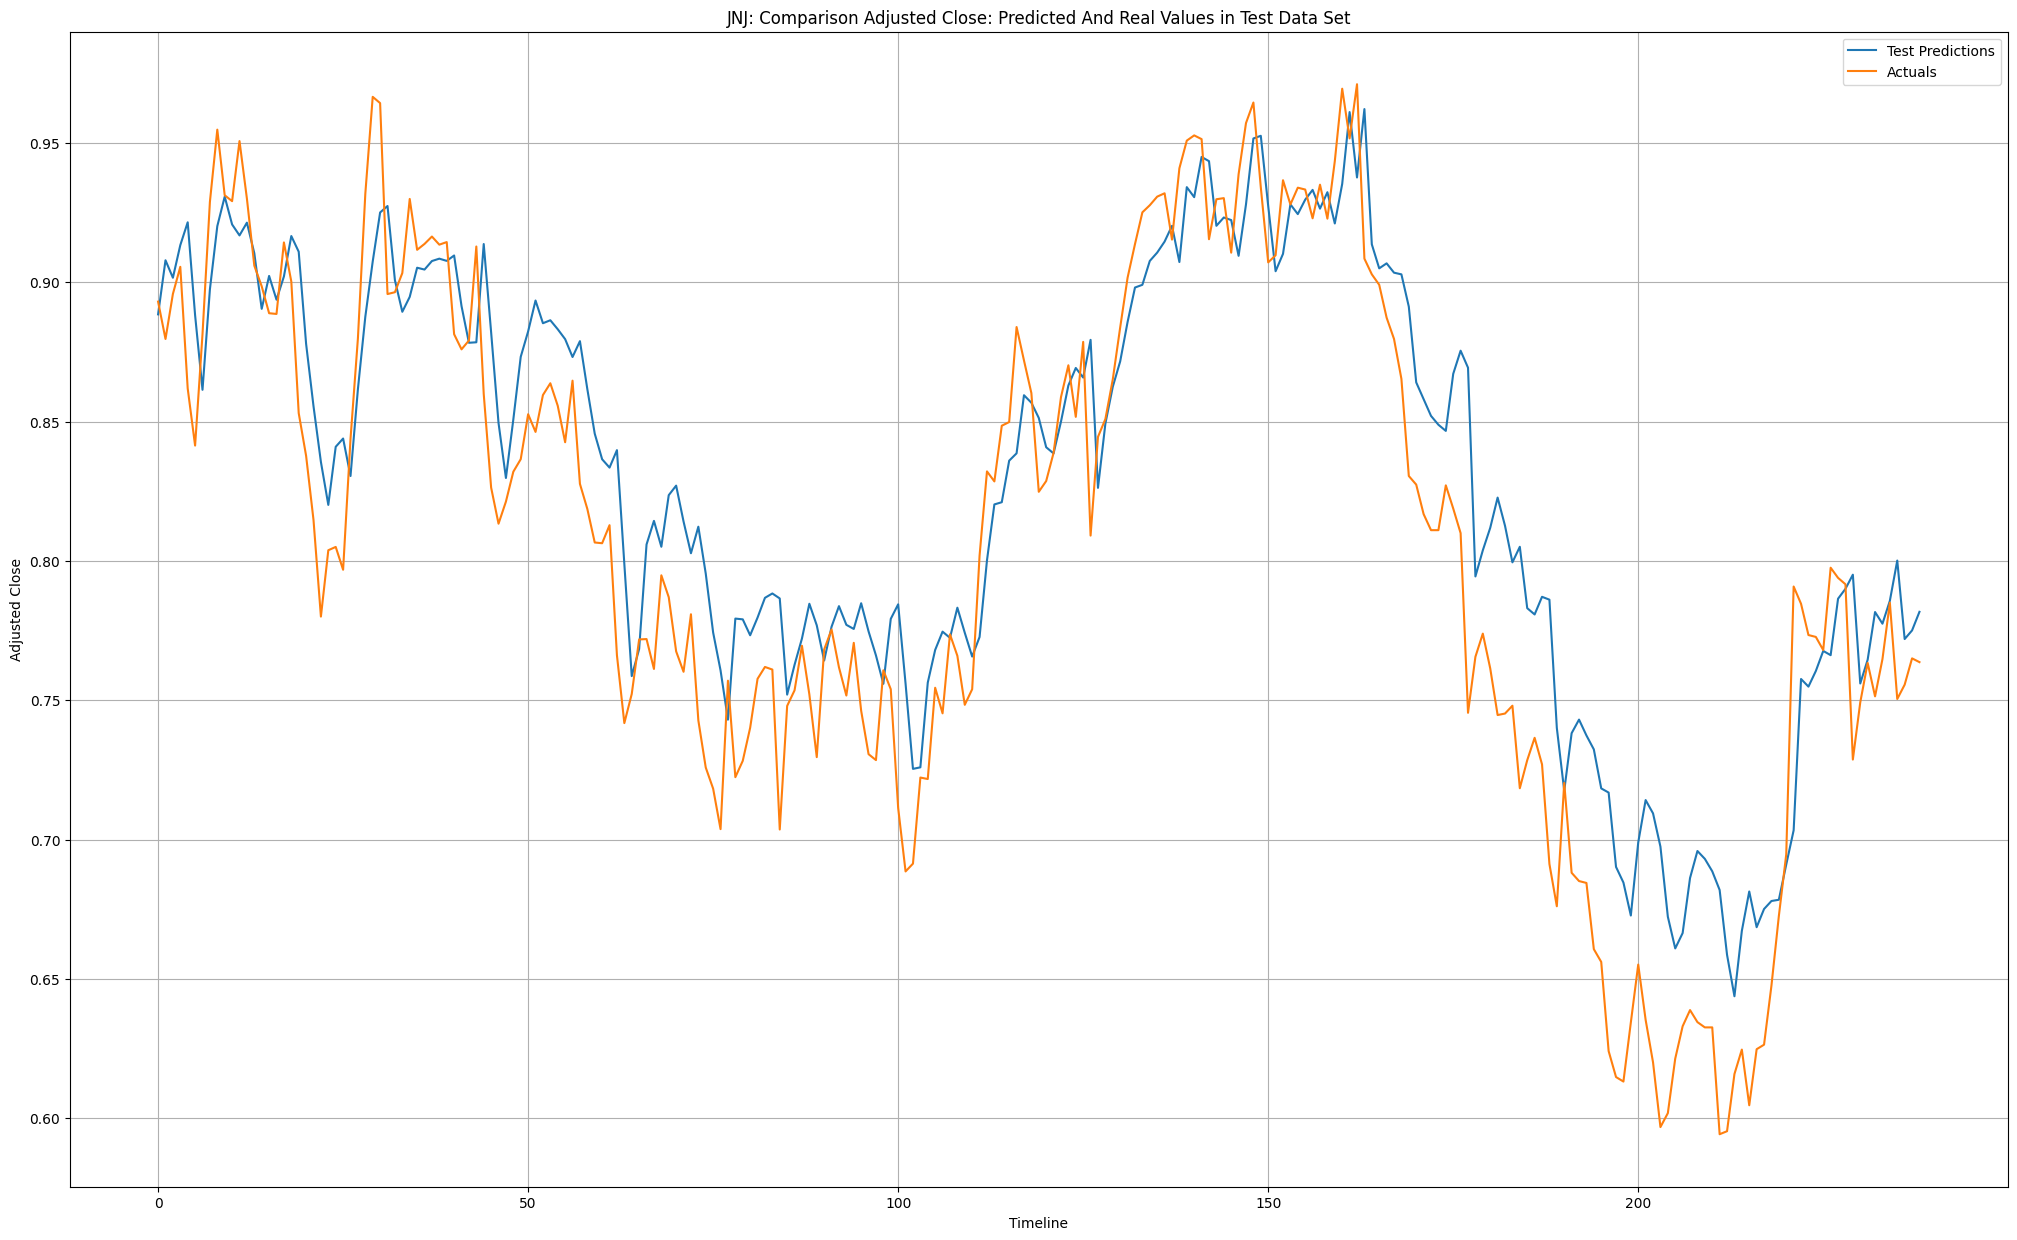

In [476]:
# plot test and ground truth data
plt.figure(figsize=(25, 15))
plt.plot(test_results['Test Predictions'], label='Test Predictions')
plt.plot(test_results['Actuals'], label='Actuals')
plt.title('JNJ: Comparison Adjusted Close: Predicted And Real Values in Test Data Set')
plt.ylabel('Adjusted Close')
plt.xlabel('Timeline')
plt.legend()
plt.grid()

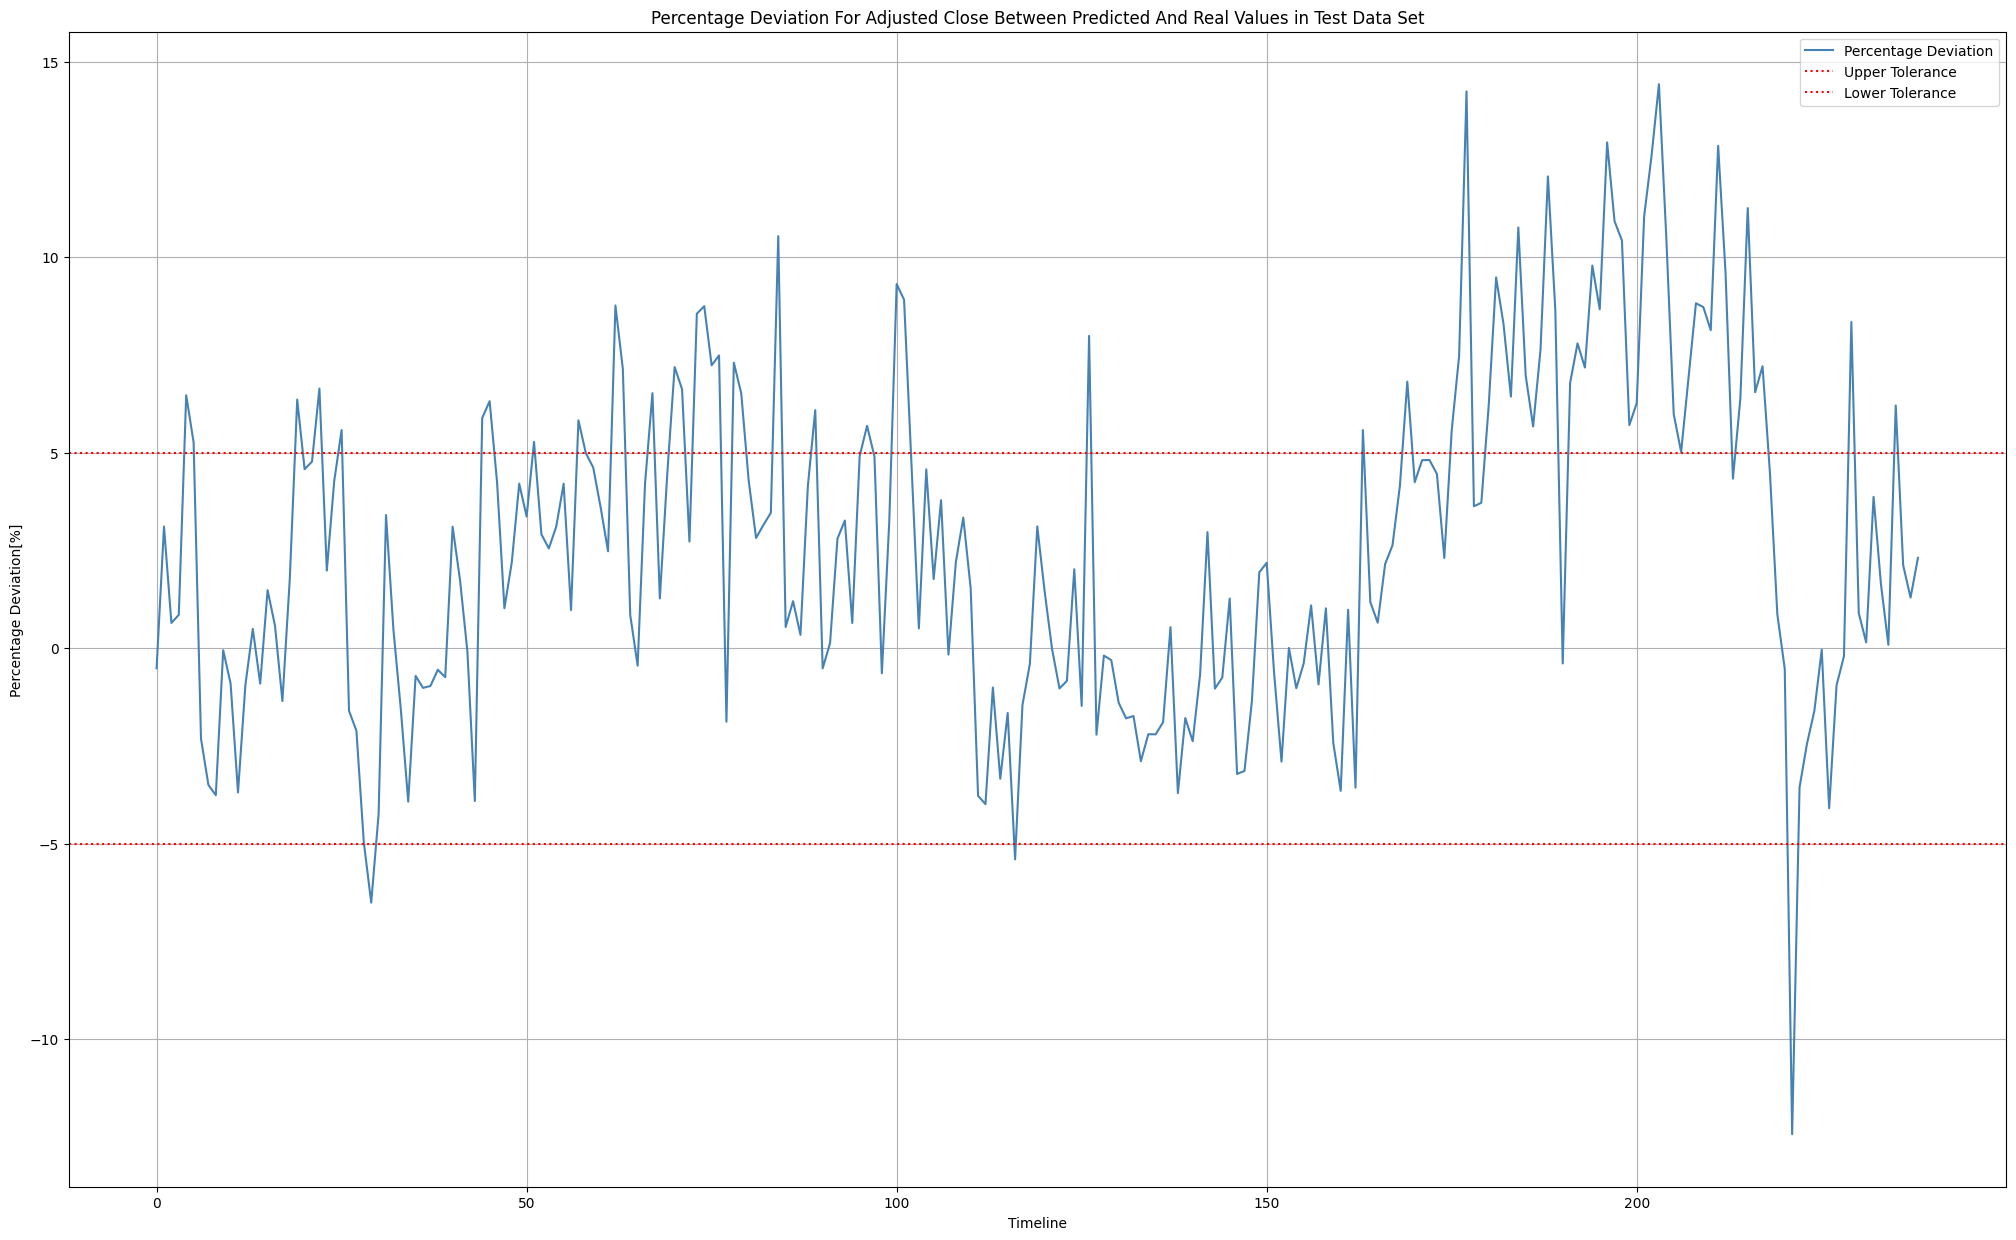

The mean for the percentage deviation in the test data is 2.6373117681184453.
The MSE for the test data is 0.002624735003337264.


In [477]:
# plot for percentage deviation between predicted and real values in test data 

# calculate the Percentage Deviation
diff_test = test_results['Test Predictions']-test_results['Actuals']
rel_diff_test = diff_test / test_results['Test Predictions']
percent_diff_test = rel_diff_test * 100

# plotting
plt.figure(figsize=(25, 15))
plt.plot(percent_diff_test.index, percent_diff_test, color='steelblue', label='Percentage Deviation')
plt.axhline(y=5, color='r', linestyle=':', label='Upper Tolerance')
plt.axhline(y=-5, color='r', linestyle=':', label='Lower Tolerance')
plt.grid()
plt.legend()
plt.ylabel('Percentage Deviation[%]')
plt.xlabel('Timeline')
plt.title('Percentage Deviation For Adjusted Close Between Predicted And Real Values in Test Data Set')
plt.show()
print('The mean for the percentage deviation in the test data is {}.'.format(np.mean(percent_diff_test)))
print('The MSE for the test data is {}.'.format(best_mse))

The LTSM model showed that it can perform in the desired tolerance. Now I define a function which find the best windows size and saves the model for all stocks.

**Information**: I tried different hyperparameter (e.g., learning_rate, window_size) to get this performance. 

In [319]:
def ltsm_model(dfs):
    """
    Create LSTM models for each dataset in Xs_nor and return the best performing models.
    
    INPUT
        dfs - (dict) A dictionary with stock datasets.
    
    
    OUTPUT
        best_models - (dict) A dictionary containing the best performing model, its accuracy, mse and window_size for each dataset.
    """
    
   
    # initialize a dictionary to store the best performing model and its accuracy for each dataset
    best_models = {}
    
    
    # loop through each dataset in dfs
    for name in dfs:
        
        print(name)
        
        # initialize a dictionary to store the best performing model and its accuracy for the current dataset
        best_models[name] = {}
        
        # loop through different window sizes
        for window_size in range(1, 5):
            
            print(window_size)
            
            # remove error messages from tensorflow
            absl.logging.set_verbosity(absl.logging.ERROR)
            logging.getLogger('tensorflow').disabled = True
            
            # create a sequential model with an LSTM layer, a dense layer with ReLU activation, and a linear output layer
            model = Sequential()
            model.add(LSTM(64))
            model.add(Dense(8, activation='relu'))
            model.add(Dense(17, activation='linear')) # output of 17 features
    
            # compile the model with mean squared error loss, Adam optimizer, and root mean squared error metric
            model.compile(loss='mse', optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
            
            # create a sequential model with an LSTM layer, a dense layer with ReLU activation, and a linear output layer
            model.add(InputLayer((window_size, 17))) # the first parameter is always the window size, the second the number of features
                        
            # split the data into training, validation, and testing sets using the current window size
            Xs_train, Xs_val, Xs_test, ys_train, ys_val, ys_test = train_test_lstm(dfs, window_size)
            
            # create a callback to save the best performing model
            cp = ModelCheckpoint('model/', save_best_only=True, verbose=0)
            
            # train the model with the training data and validate with the validation data
            history = model.fit(np.array(Xs_train[name]), np.array(ys_train[name]), validation_data=(np.array(Xs_val[name]), np.array(ys_val[name])), epochs=50, callbacks=[cp], verbose=0)
            
            # load the best performing model
            model = load_model('model/')
            
            # make predictions on the testing data
            test_predictions = model.predict(np.array(Xs_test[name]))
            
            # select the Adjusted Close for prediction (last column)
            test_predictions = [arr[-1] for arr in test_predictions]
            
            # select the Adjusted Close for test data (last column)
            ground_true = [arr[-1] for arr in ys_test[name]]
            
            # calculate the percent difference between the predictions and ground truth
            diff_test = np.array(test_predictions) - np.array(ground_true)
            percent_diff_test = np.mean(np.abs(diff_test / test_predictions) * 100)
            
            # get the best mse from the best model
            best_mse = history.history['val_loss'][np.argmin(history.history['val_loss'])]
            
            # if this is the first window size, set the accuracy to the current percent difference
            if window_size == 1:
                
                best_models[name]['model'] = model
                best_models[name]['accuracy'] = percent_diff_test
                best_models[name]['mse'] = best_mse
                best_models[name]['window_size'] = window_size
            
            # otherwise, compare the current accuracy to the previous best accuracy and update if necessary
            else:
                
                if best_models[name]['mse'] > best_mse:
                    
                    best_models[name]['model'] = model
                    best_models[name]['accuracy'] = percent_diff_test
                    best_models[name]['mse'] = best_mse
                    best_models[name]['window_size'] = window_size
                
                else:
                    
                    continue
                
    return best_models

In [320]:
# get the best models
best_models = ltsm_model(dfs_nor)

BMW.DE
1
8/8 [==============================] - 0s 621us/step
2
8/8 [==============================] - 0s 597us/step
3
8/8 [==============================] - 0s 637us/step
4
8/8 [==============================] - 0s 687us/step
BTC-USD
1
12/12 [==============================] - 0s 491us/step
2
12/12 [==============================] - 0s 575us/step
3
12/12 [==============================] - 0s 704us/step
4
12/12 [==============================] - 0s 615us/step
ETSY
1
8/8 [==============================] - 0s 813us/step
2
8/8 [==============================] - 0s 664us/step
3
8/8 [==============================] - 0s 647us/step
4
8/8 [==============================] - 0s 722us/step
JNJ
1
8/8 [==============================] - 0s 594us/step
2
8/8 [==============================] - 0s 599us/step
3
8/8 [==============================] - 0s 661us/step
4
8/8 [==============================] - 0s 739us/step
TSLA
1
8/8 [==============================] - 0s 547us/step
2
8/8 [=====================

In [326]:
best_models

{'BMW.DE': {'model': <keras.engine.sequential.Sequential at 0x300b91a20>,
  'accuracy': 5.35931490494744,
  'mse': 0.008879450149834156,
  'window_size': 2},
 'BTC-USD': {'model': <keras.engine.sequential.Sequential at 0x2f1b6b2b0>,
  'accuracy': 4.7877469127643275,
  'mse': 0.0078067537397146225,
  'window_size': 2},
 'ETSY': {'model': <keras.engine.sequential.Sequential at 0x2c6ce8ee0>,
  'accuracy': 5.1850233878988,
  'mse': 0.006888950243592262,
  'window_size': 1},
 'JNJ': {'model': <keras.engine.sequential.Sequential at 0x29acbe020>,
  'accuracy': 2.5882376061754795,
  'mse': 0.0026205643080174923,
  'window_size': 1},
 'TSLA': {'model': <keras.engine.sequential.Sequential at 0x2c2d45ae0>,
  'accuracy': 3.8157159053007828,
  'mse': 0.005145355127751827,
  'window_size': 3}}

In [346]:
def plotting_results(best_models):
    
    for name in best_models:
    
        # make prediction
        test_predictions = best_models[name]['model'].predict(np.array(Xs_test[name]))

        # select the Adjusted Close for prediction (last column)
        test_predictions = [arr[-1] for arr in test_predictions]

        # select the Adjusted Close for test data (last column)
        y_test = [arr[-1] for arr in ys_test[name]]

        # get the best mse from the best model
        best_mse = best_models[name]['mse']

        # create a dataframe with predicted values and real values
        test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals': y_test})
    
    
        # plot test and ground truth data
        print()
        print('#############')
        print(name)
        print('#############')
        print()
        plt.figure(figsize=(25, 15))
        plt.plot(test_results['Test Predictions'], label='Test Predictions')
        plt.plot(test_results['Actuals'], label='Actuals')
        plt.title('Comparison Adjusted Close: Predicted And Real Values in Test Data Set')
        plt.ylabel('Adjusted Close')
        plt.xlabel('Timeline')
        plt.legend()
        plt.grid()
    
        # plot for percentage deviation between predicted and real values in test data 

        # calculate the Percentage Deviation
        diff_test = test_results['Test Predictions']-test_results['Actuals']
        rel_diff_test = diff_test / test_results['Test Predictions']
        percent_diff_test = rel_diff_test * 100

        # plotting
        plt.figure(figsize=(25, 15))
        plt.plot(percent_diff_test.index, percent_diff_test, color='steelblue', label='Percentage Deviation')
        plt.axhline(y=5, color='r', linestyle=':', label='Upper Tolerance')
        plt.axhline(y=-5, color='r', linestyle=':', label='Lower Tolerance')
        plt.grid()
        plt.legend()
        plt.ylabel('Percentage Deviation[%]')
        plt.xlabel('Timeline')
        plt.title('Percentage Deviation For Adjusted Close Between Predicted And Real Values in Test Data Set')
        plt.show()
        print('The mean for the percentage deviation in the test data is {}.'.format(np.mean(percent_diff_test)))
        print('The MSE for the test data is {}.'.format(best_mse))
        print('The window size is {}'.format(best_models[name]['window_size']))
    
        print('---------------------------------')
    
    return None

8/8 [==============================] - 0s 2ms/step

#############
BMW.DE
#############



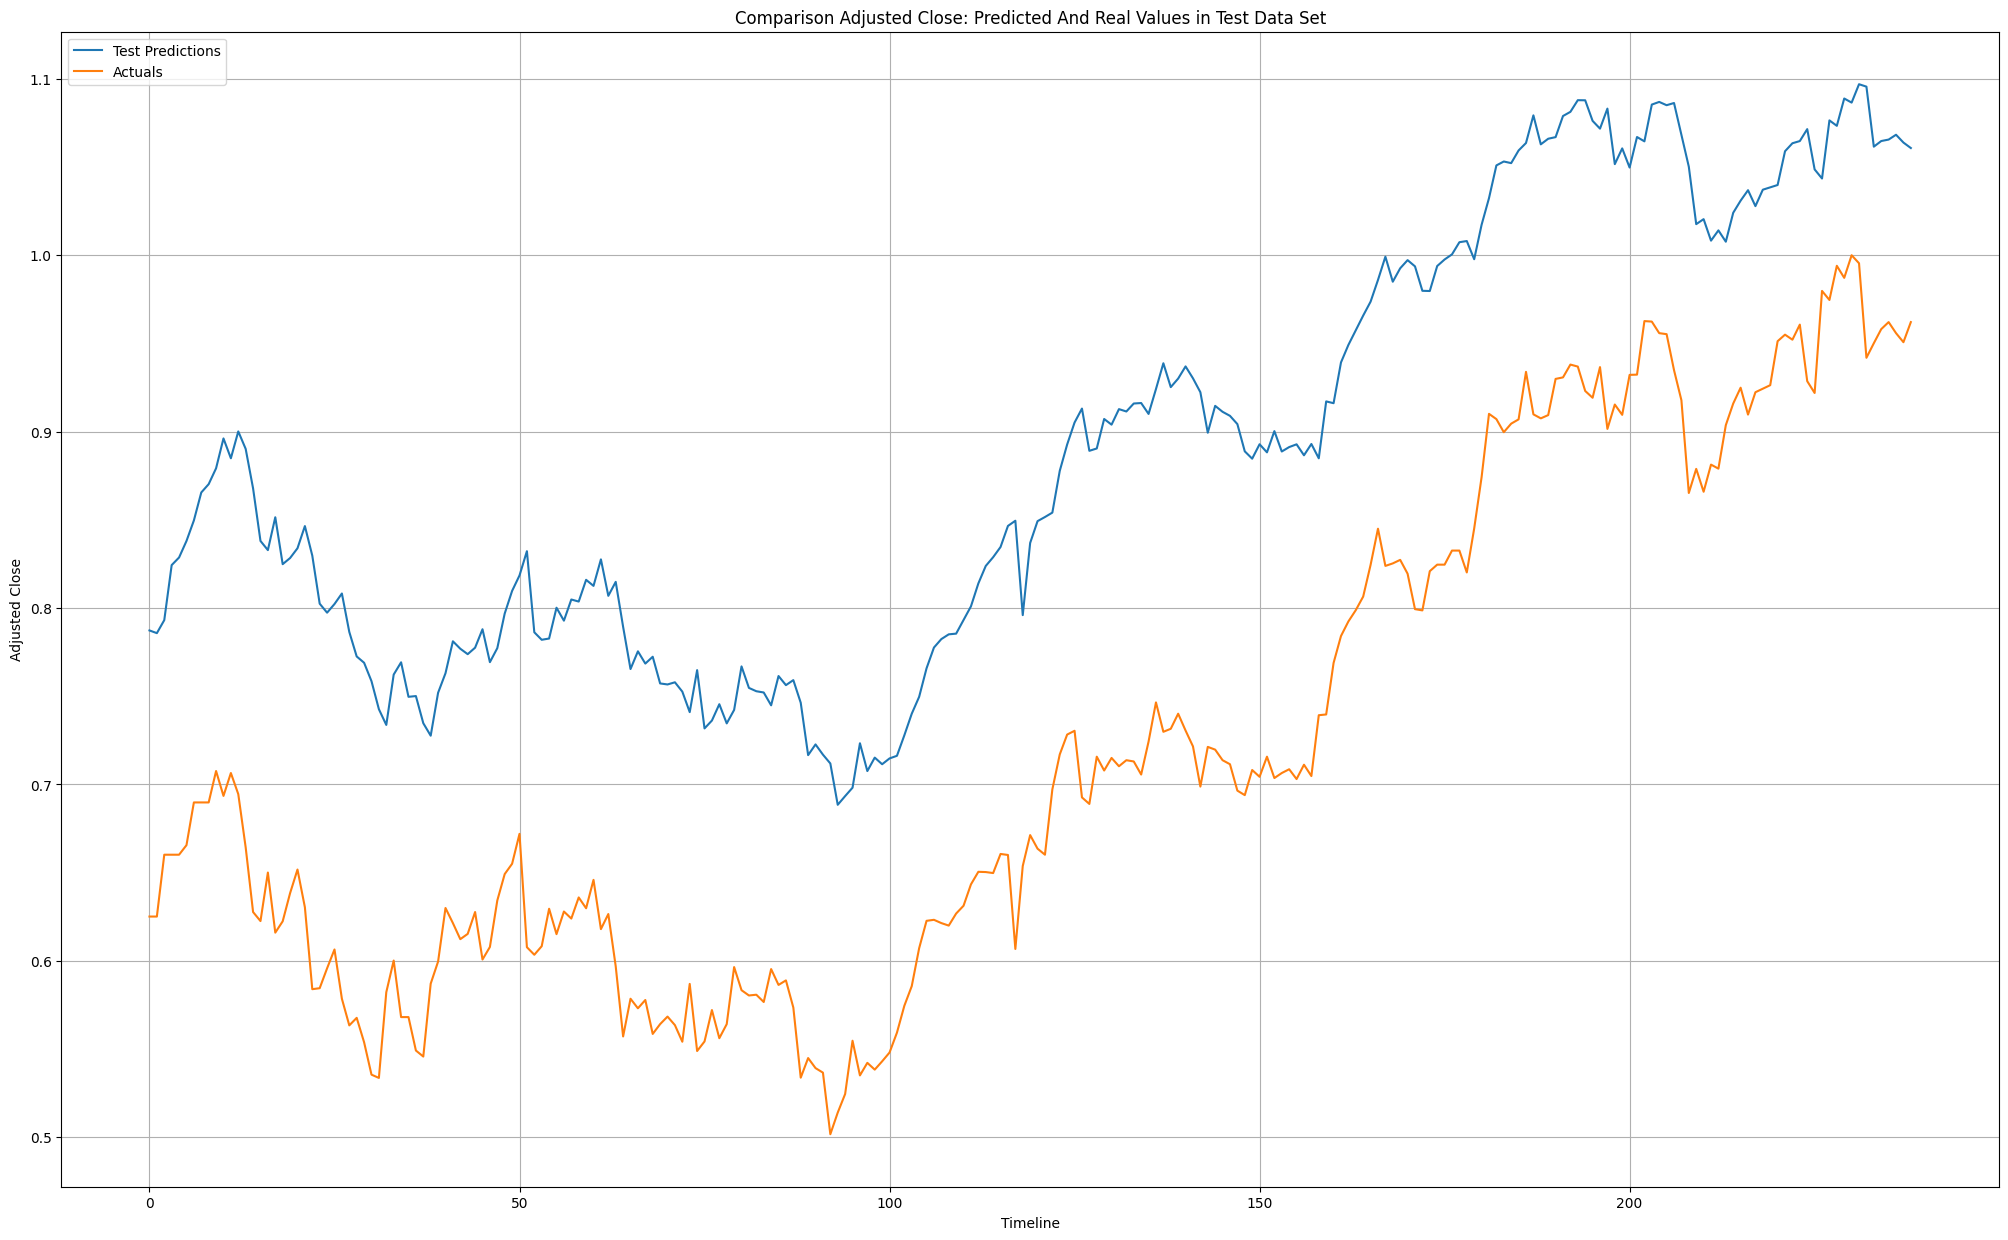

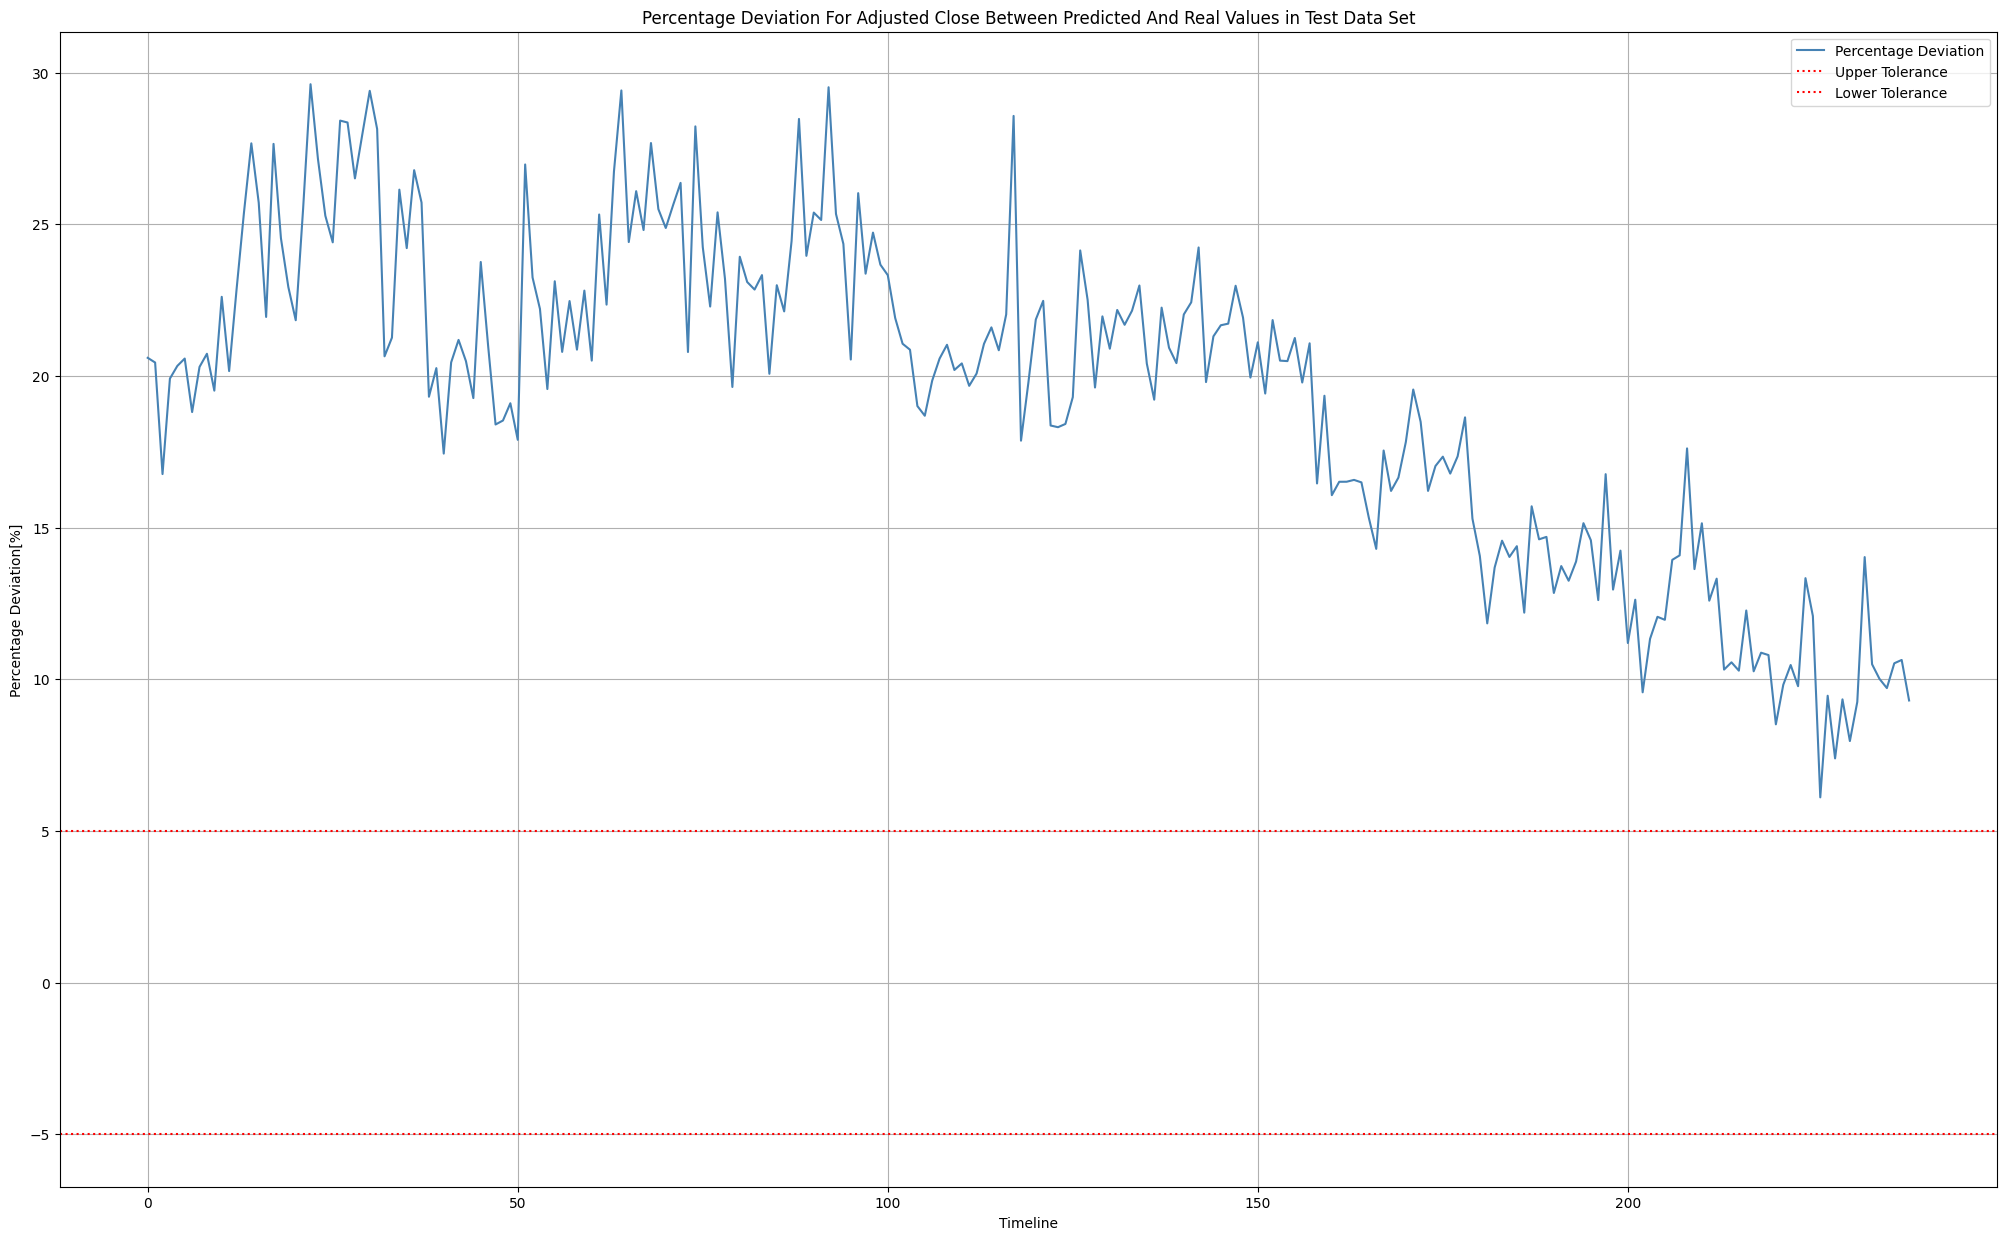

The mean for the percentage deviation in the test data is 19.45567110076852.
The MSE for the test data is 0.008879450149834156.
The window size is 2
---------------------------------
11/11 [==============================] - 0s 1ms/step

#############
BTC-USD
#############



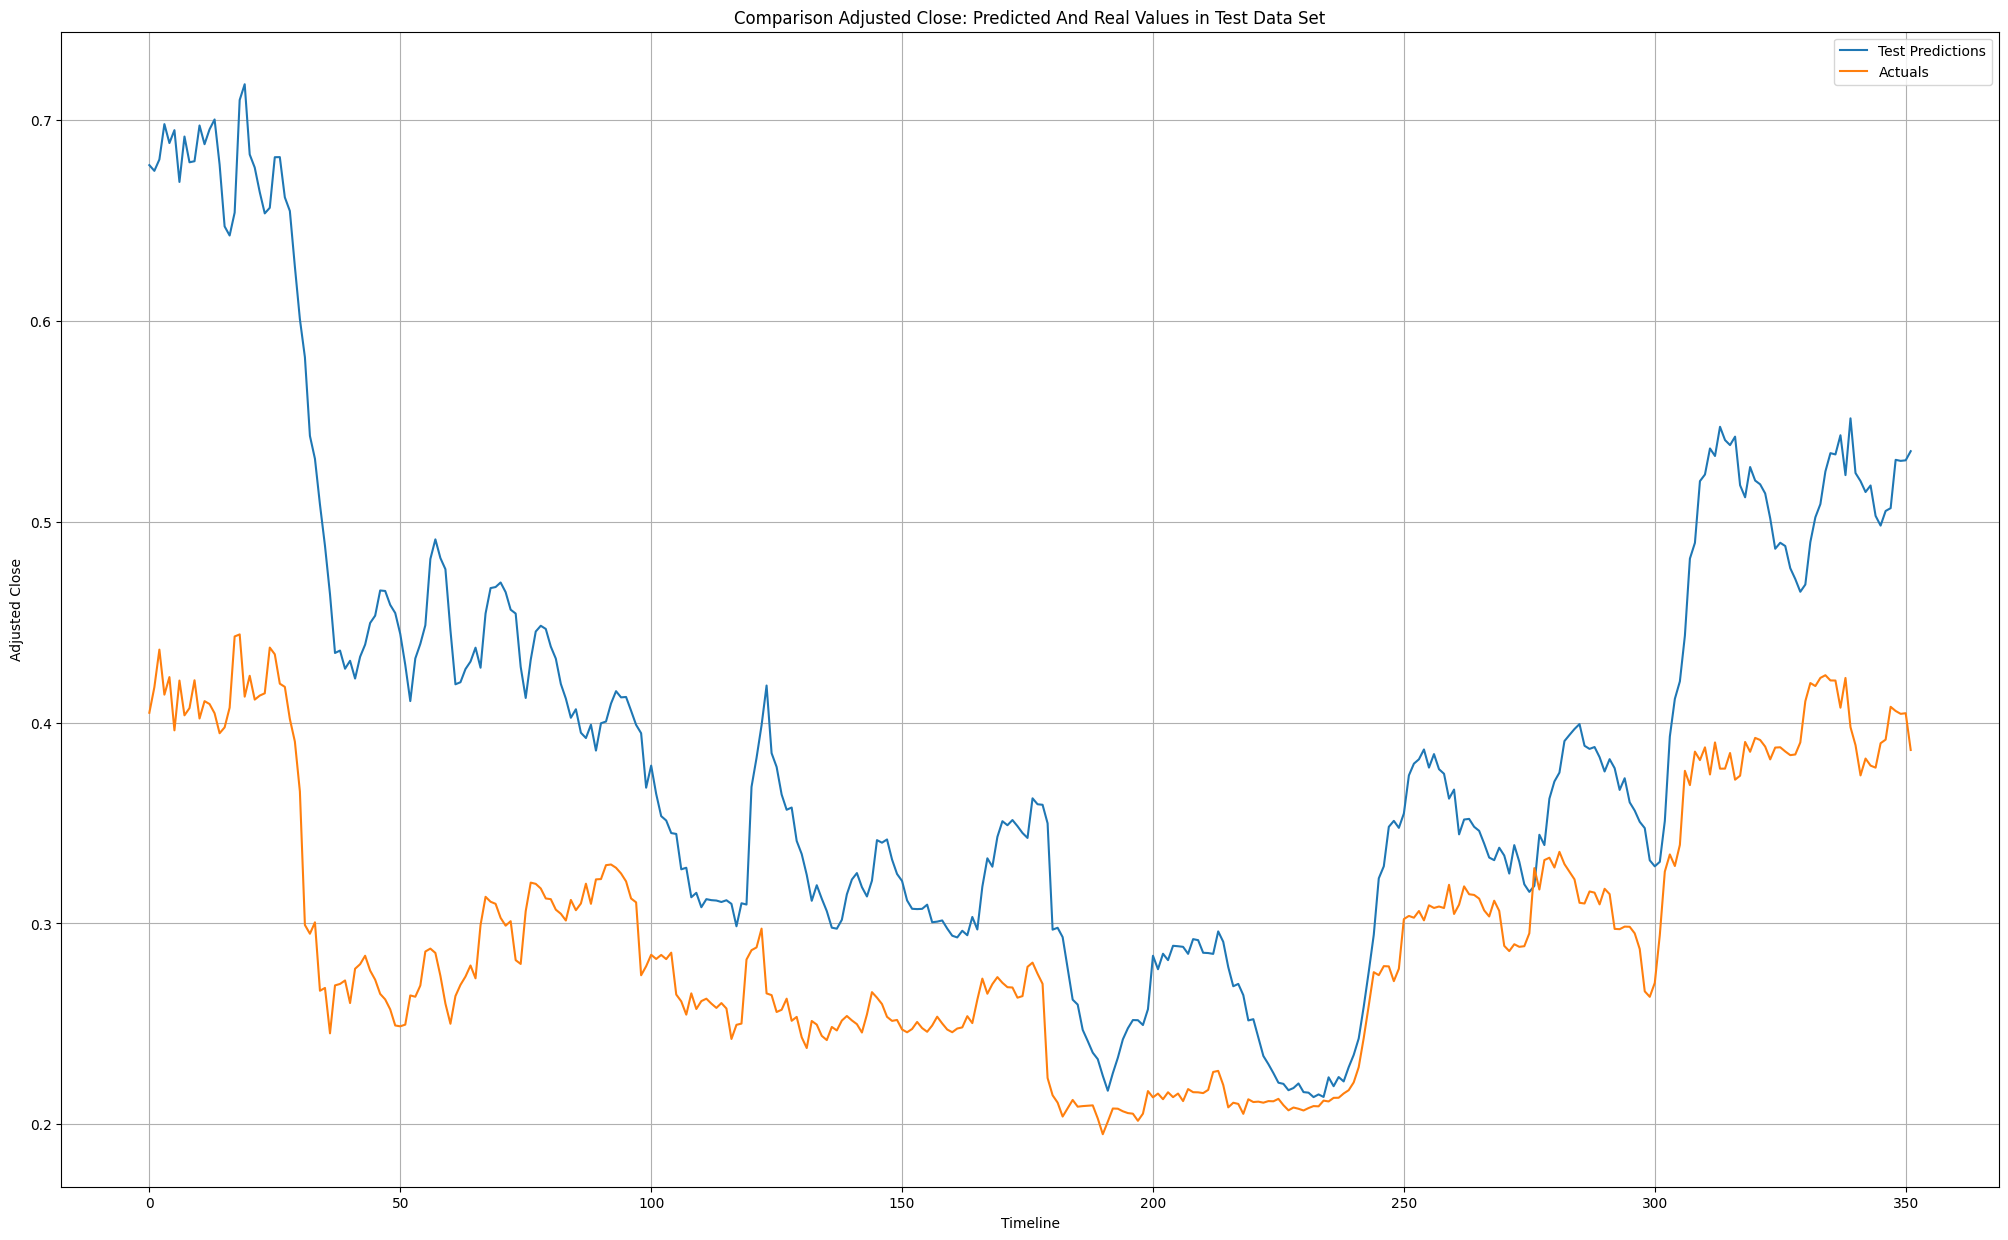

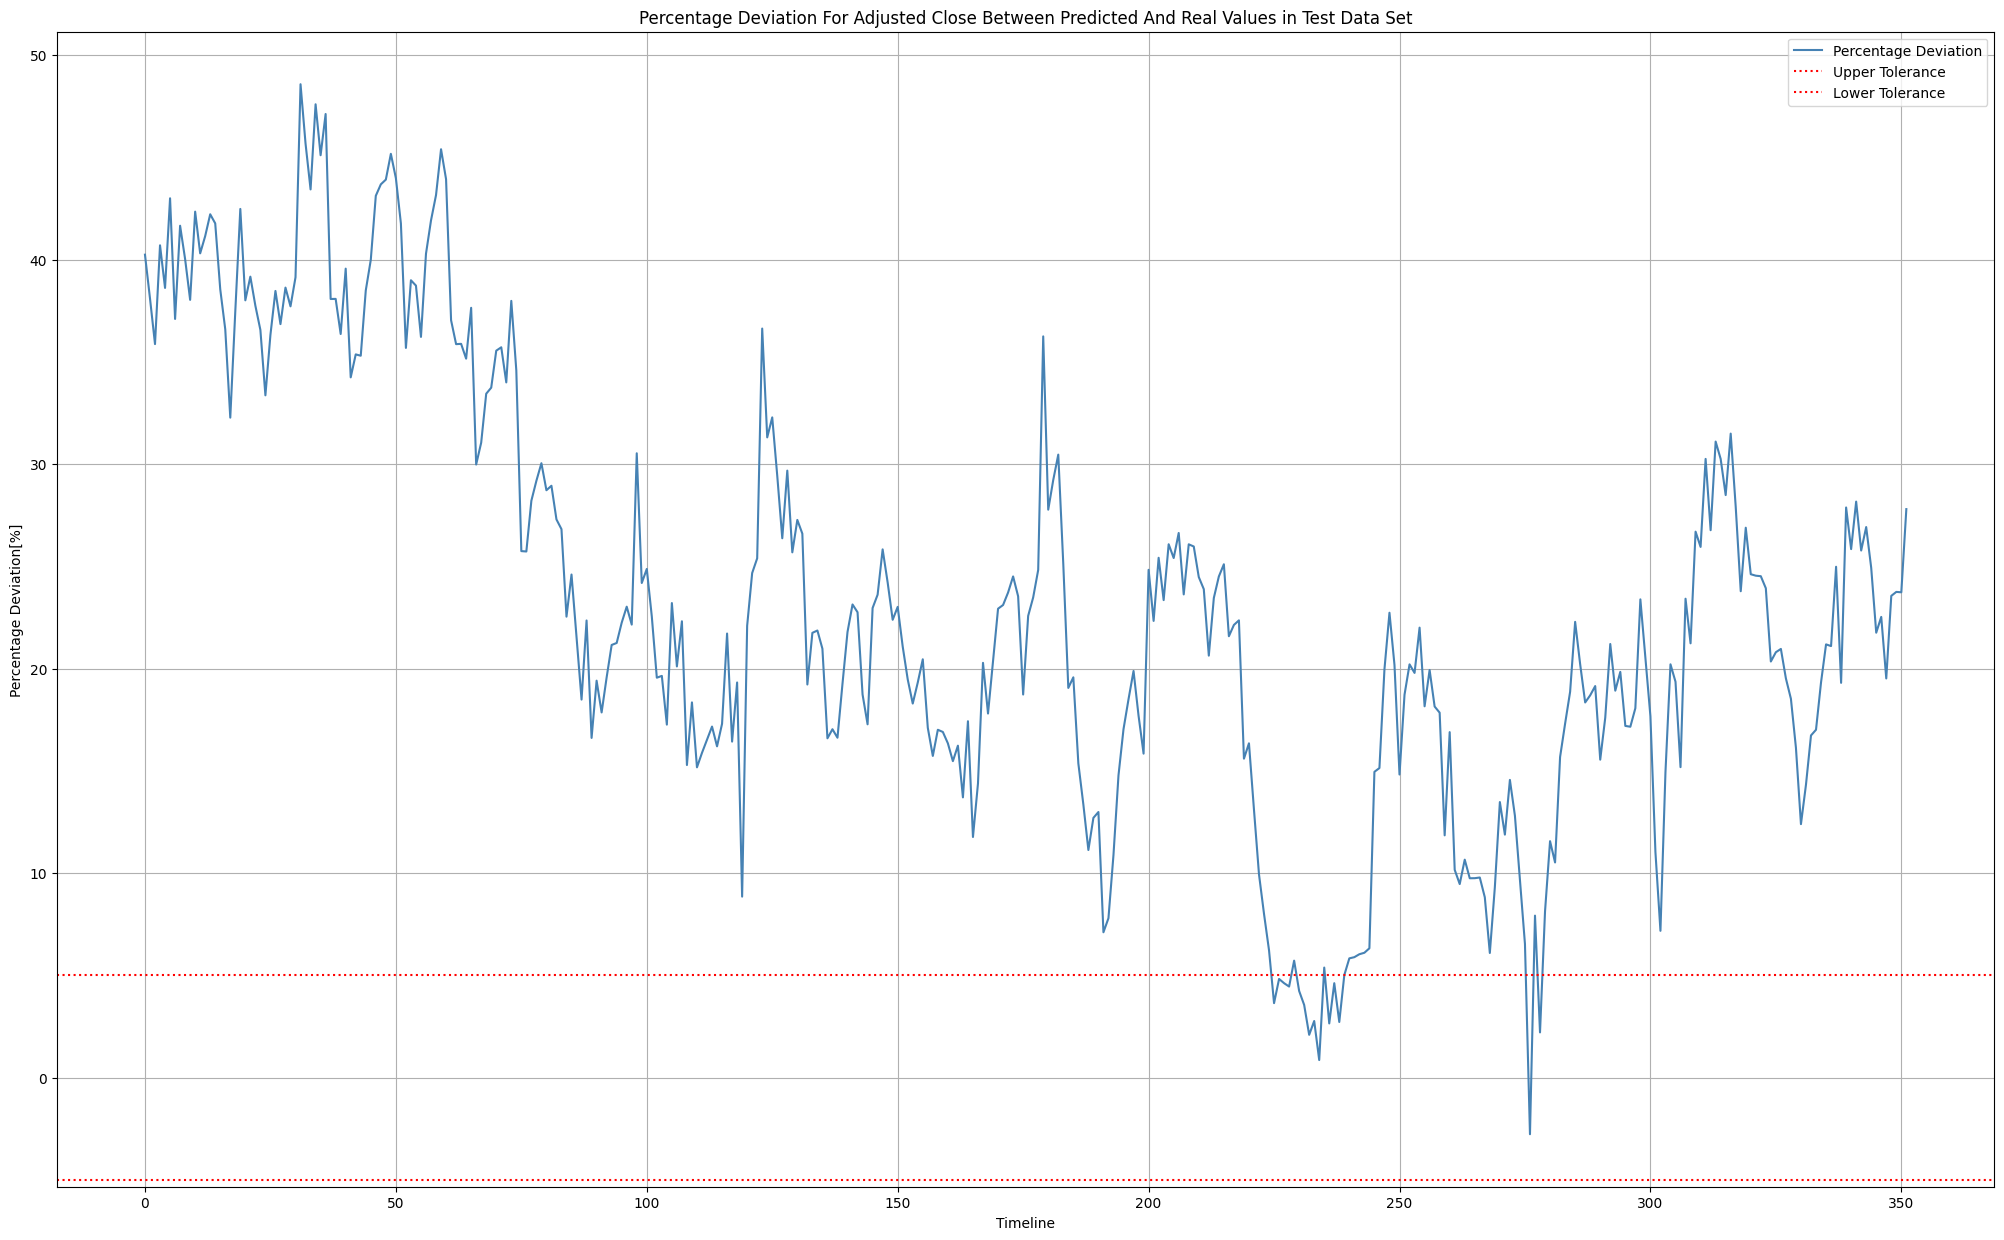

The mean for the percentage deviation in the test data is 23.139357865878836.
The MSE for the test data is 0.0078067537397146225.
The window size is 2
---------------------------------
8/8 [==============================] - 0s 2ms/step

#############
ETSY
#############



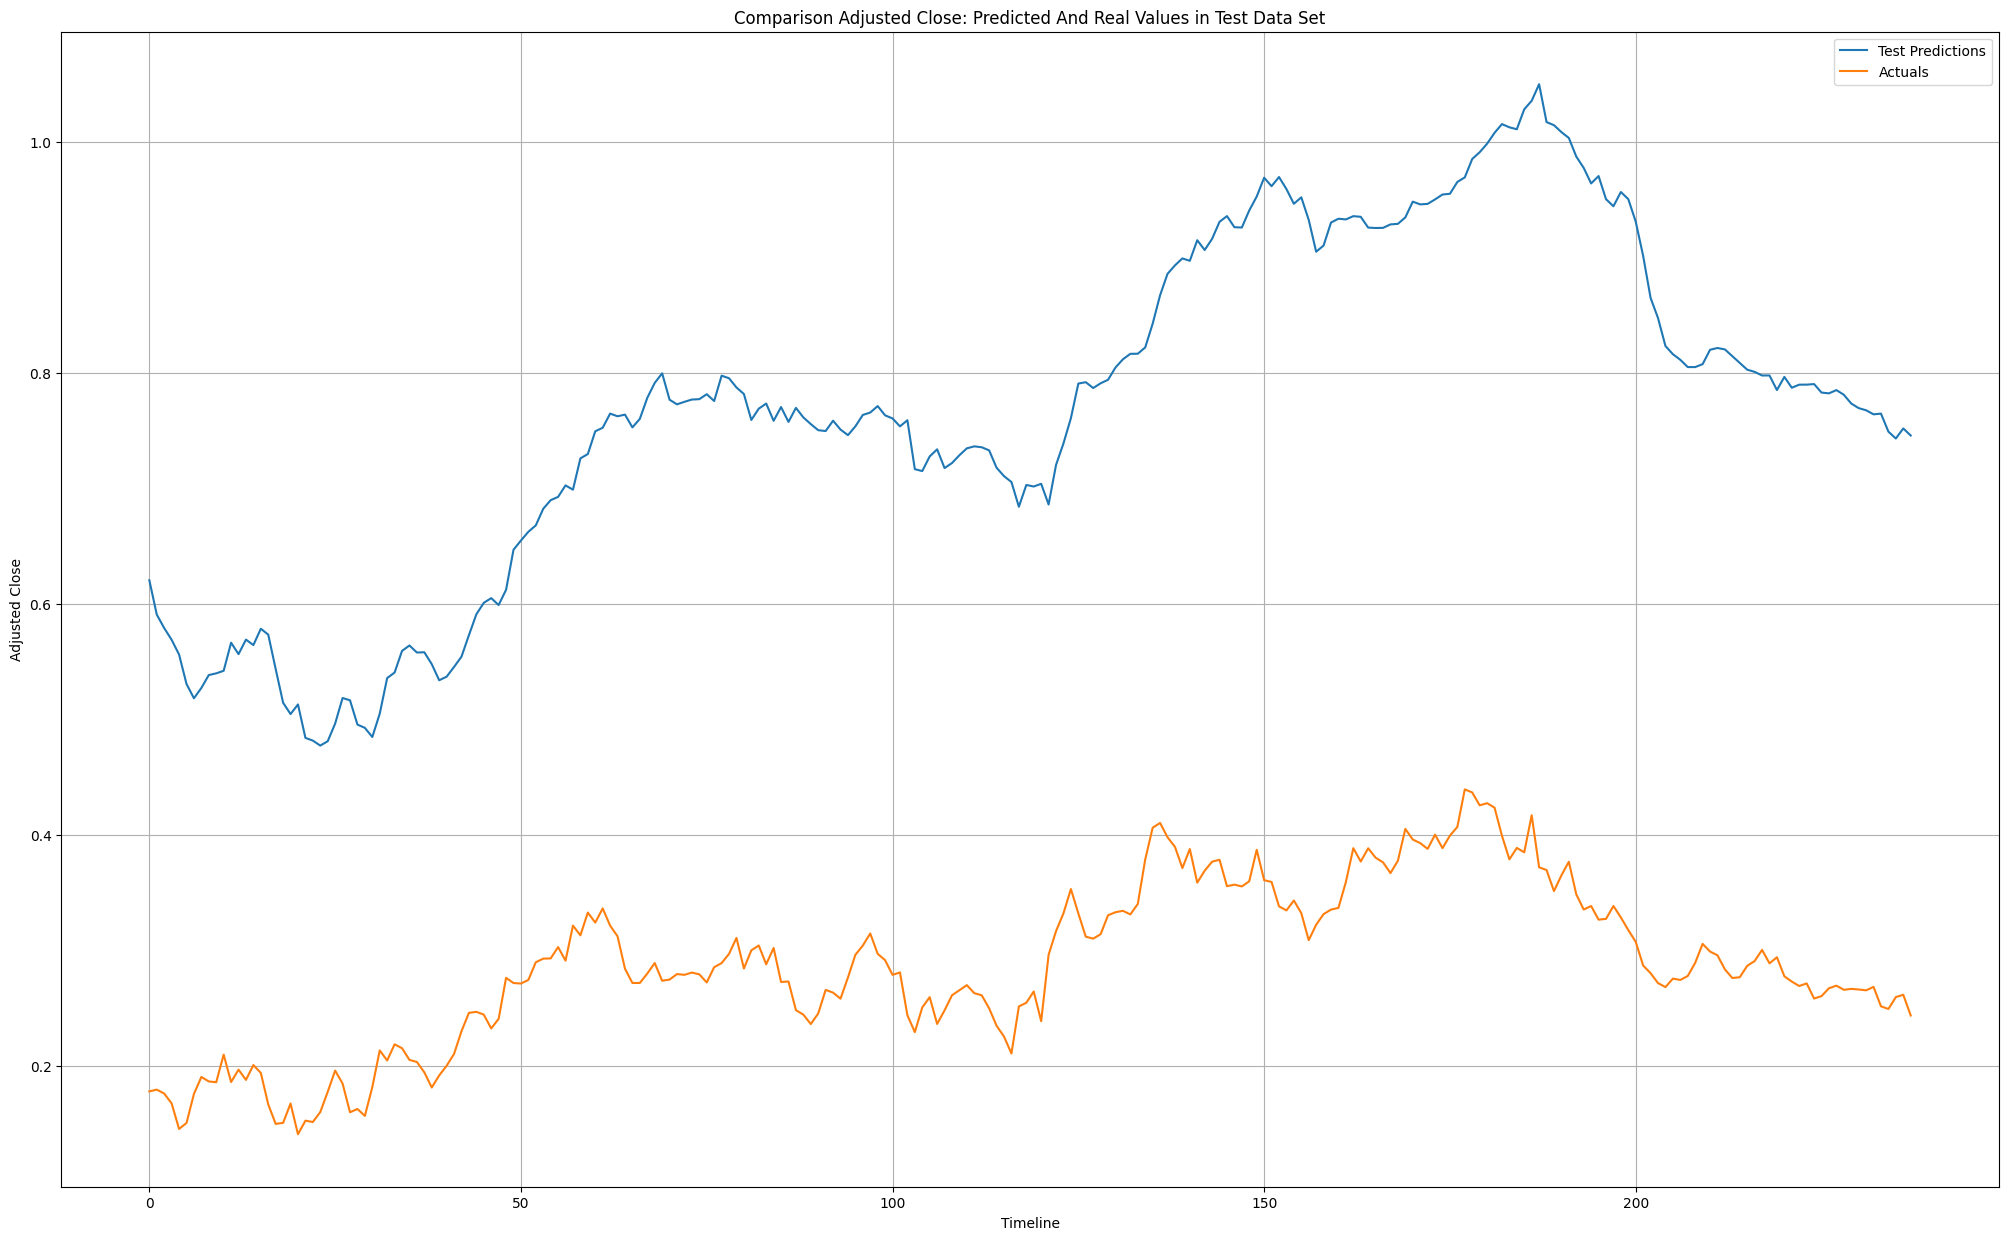

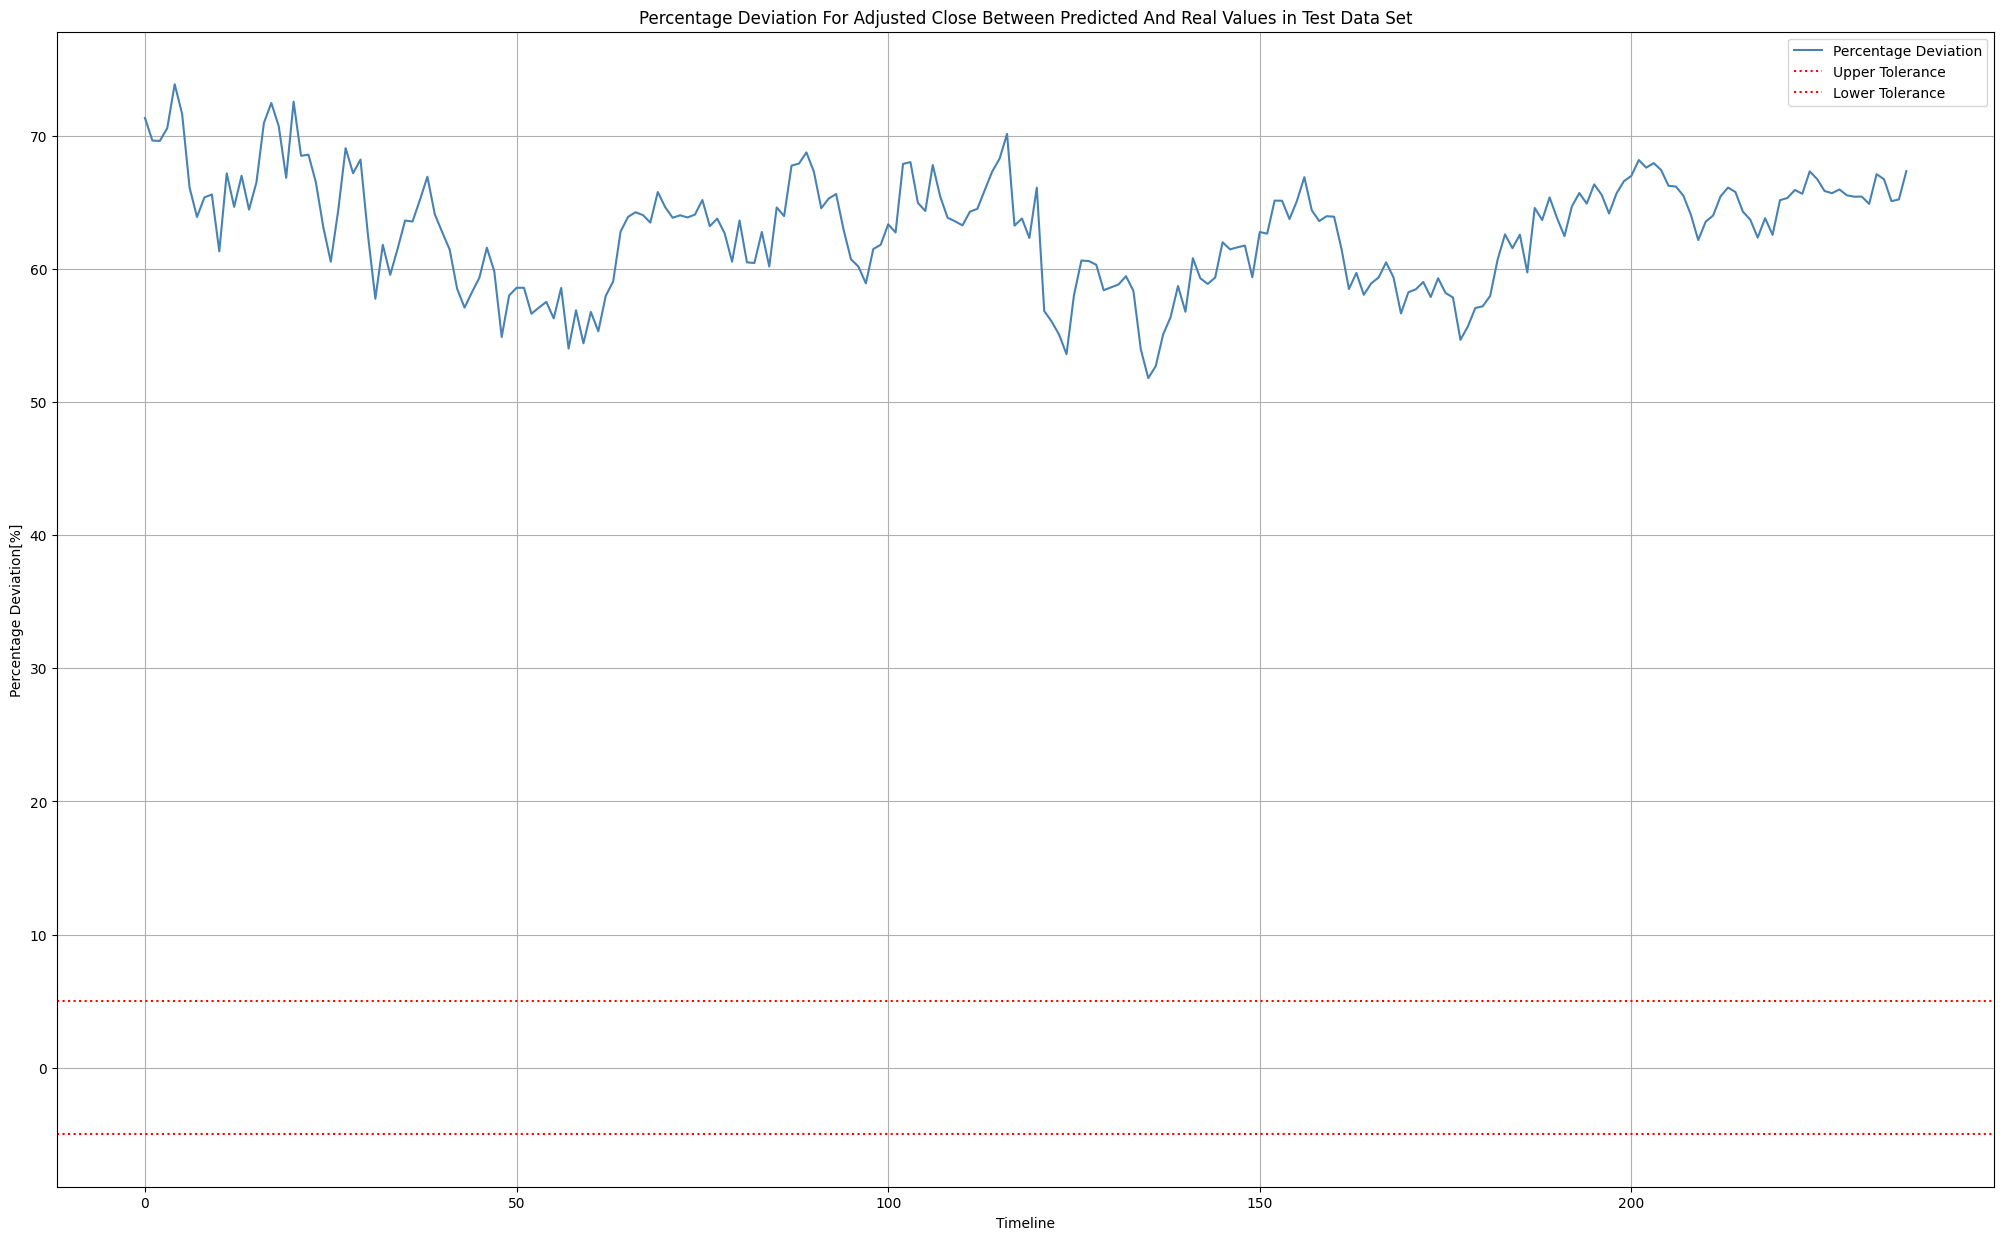

The mean for the percentage deviation in the test data is 62.872516291394305.
The MSE for the test data is 0.006888950243592262.
The window size is 1
---------------------------------
8/8 [==============================] - 0s 2ms/step

#############
JNJ
#############



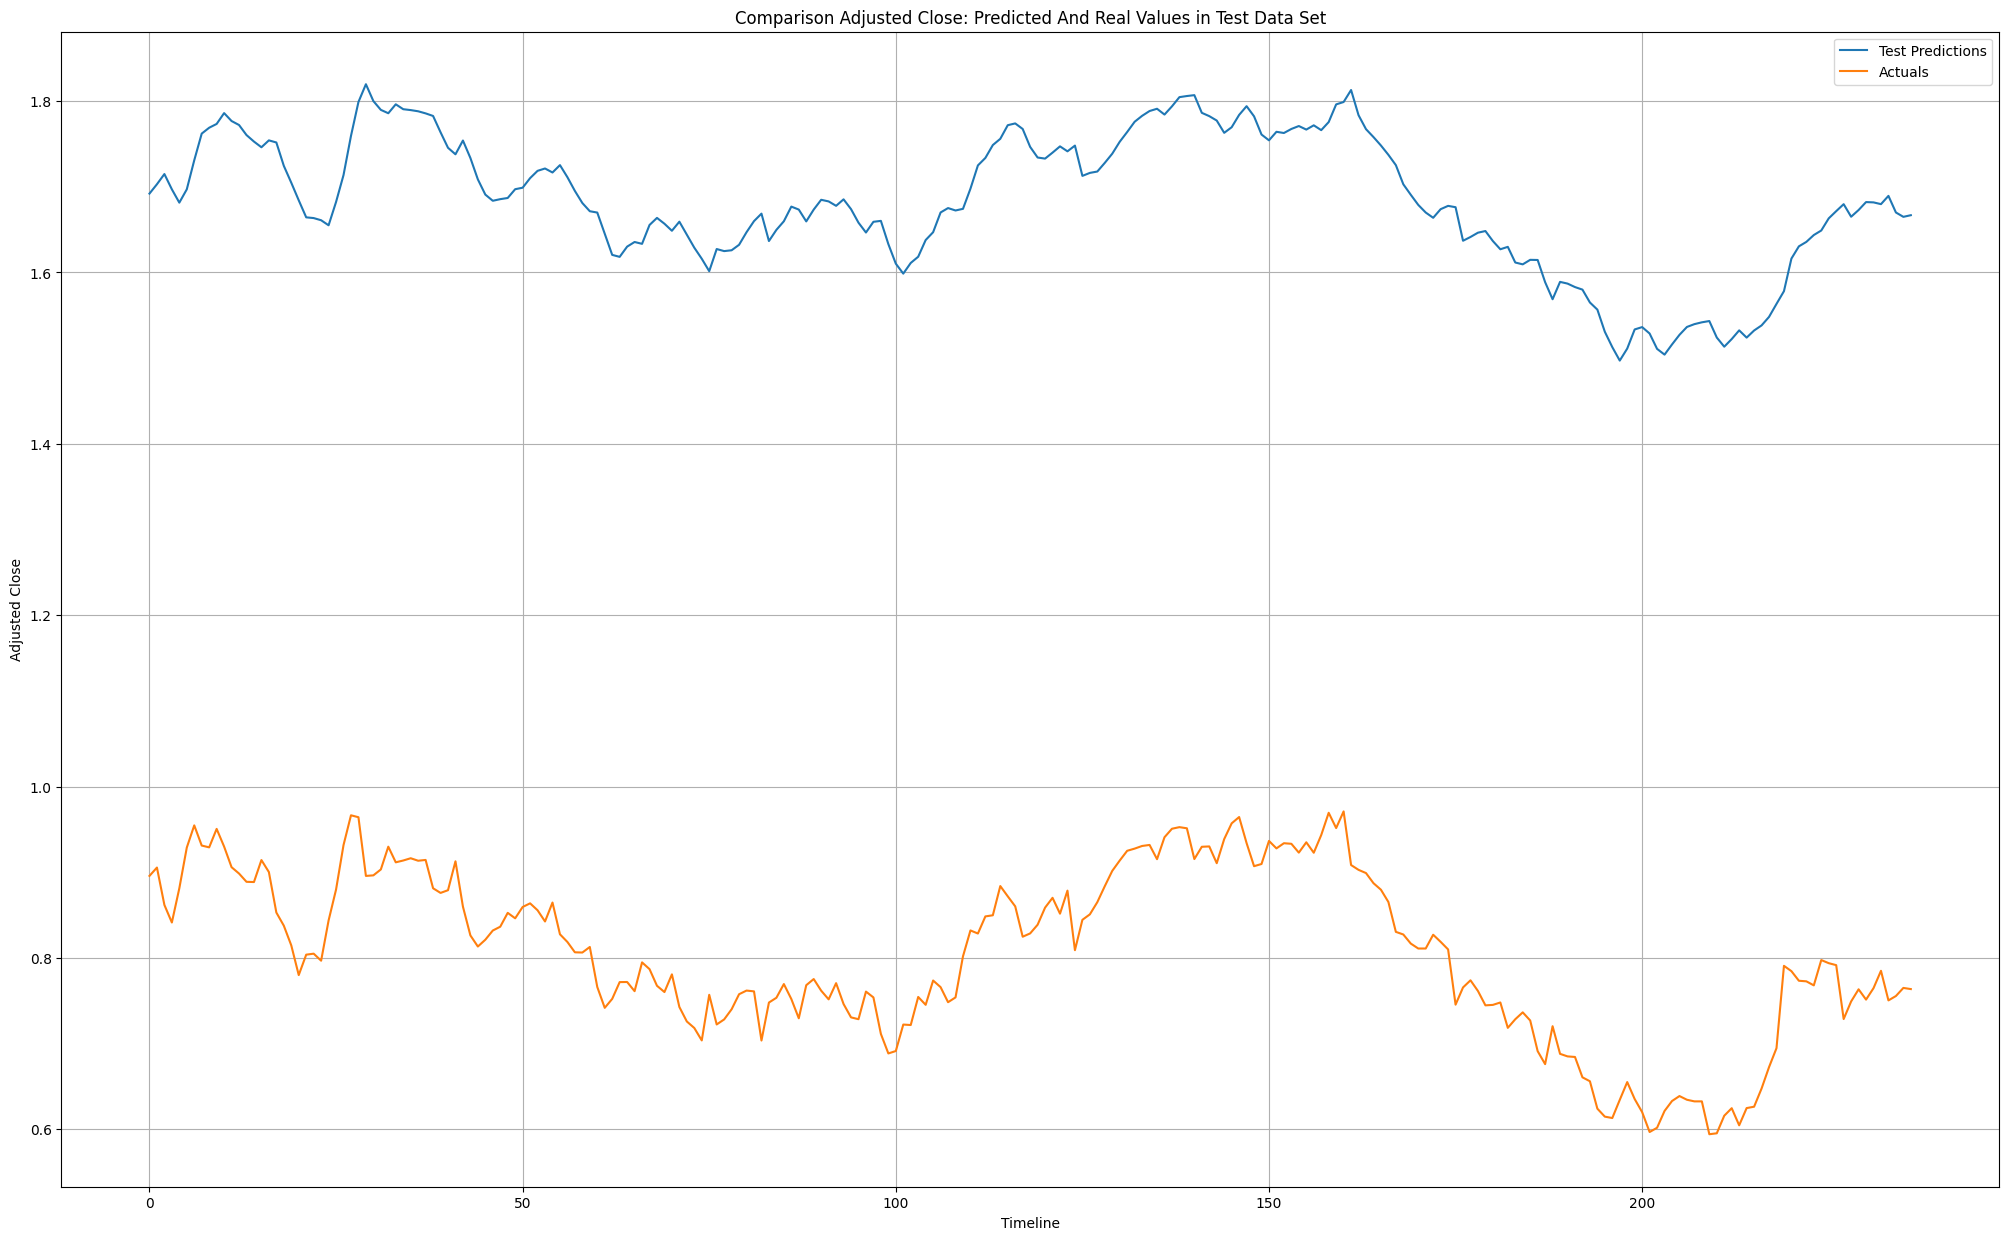

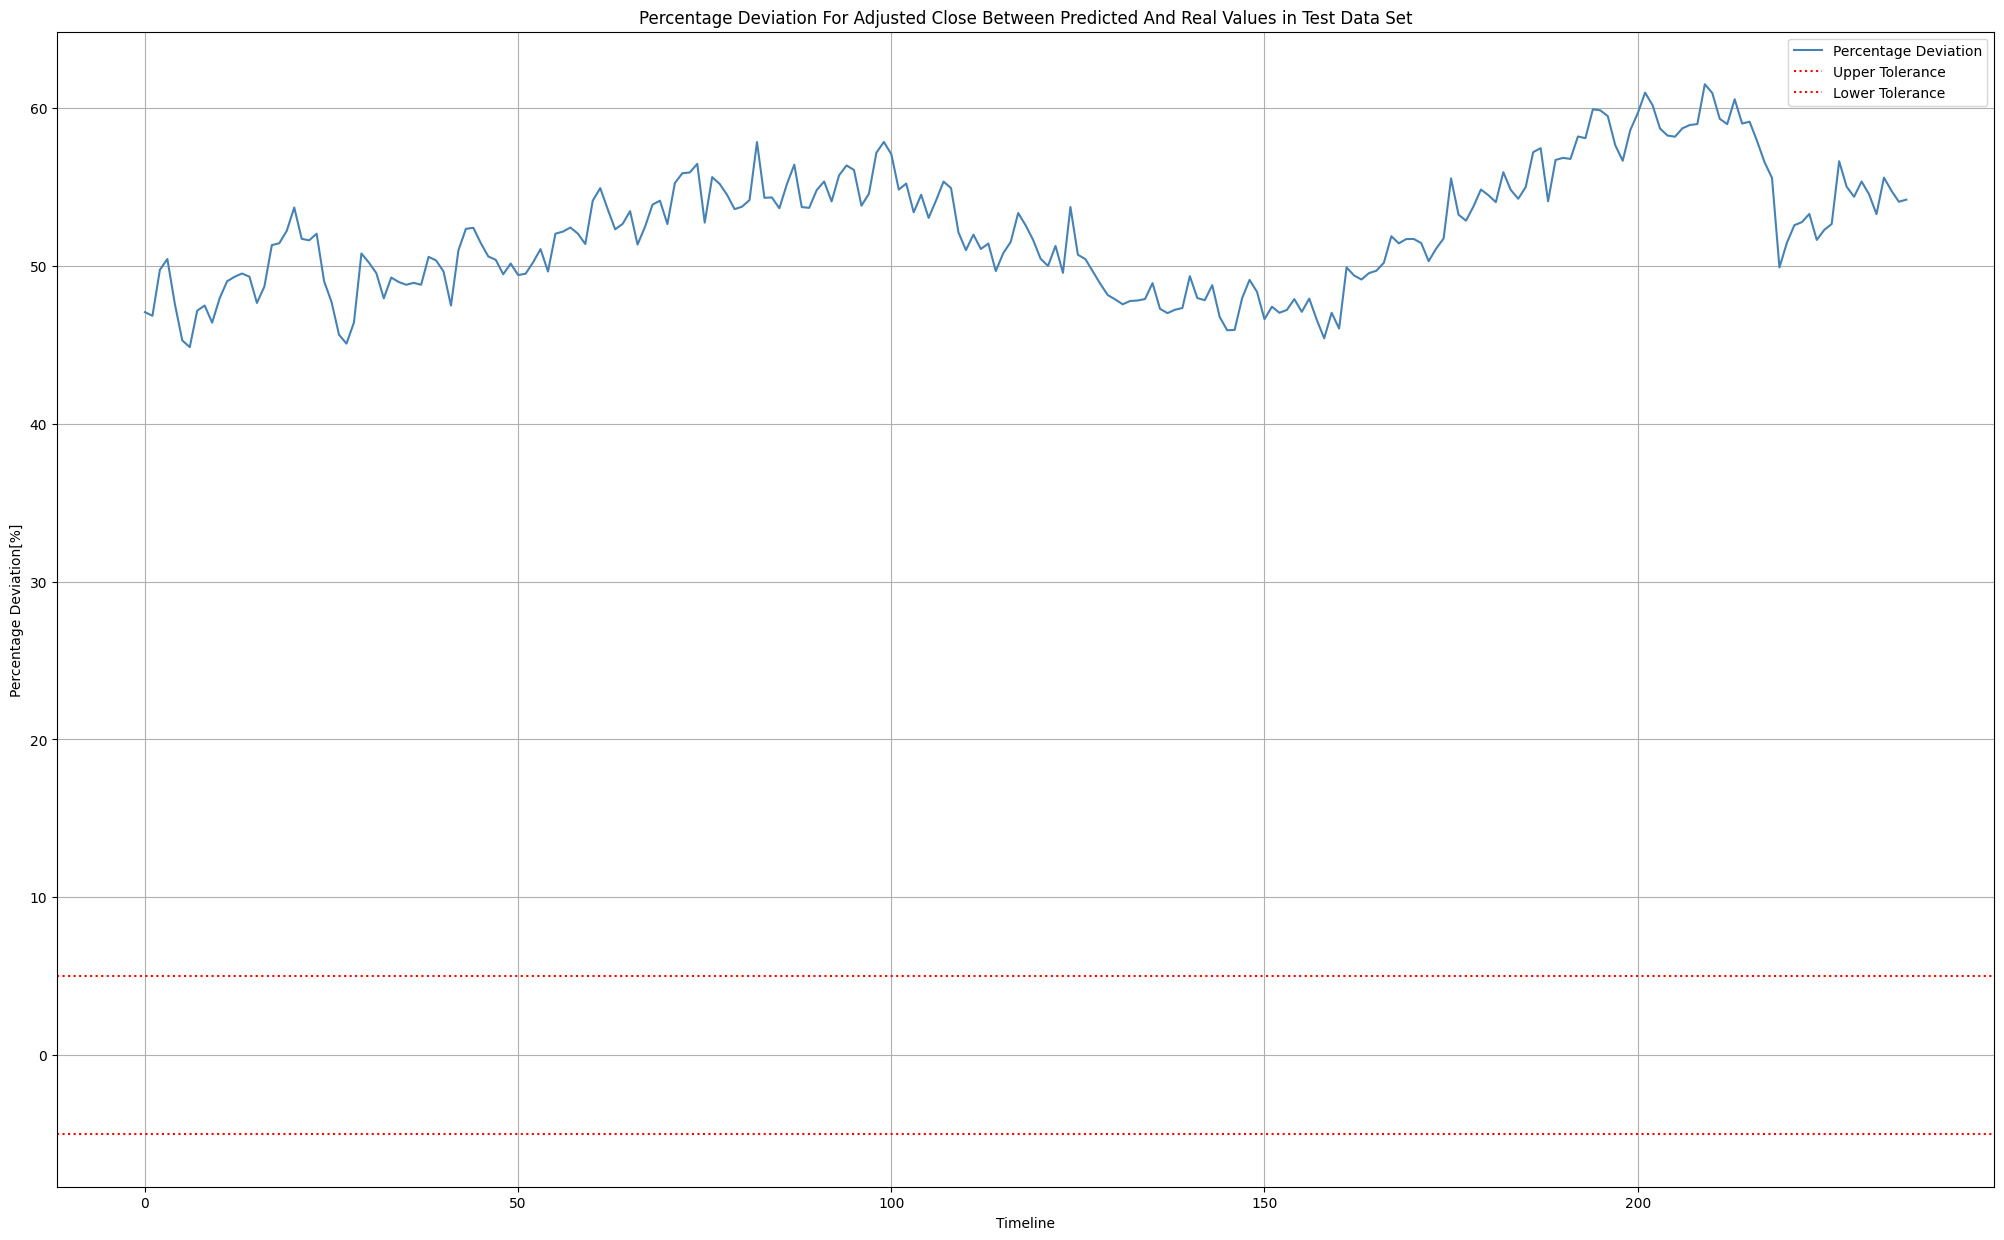

The mean for the percentage deviation in the test data is 52.26627331598951.
The MSE for the test data is 0.0026205643080174923.
The window size is 1
---------------------------------
8/8 [==============================] - 0s 2ms/step

#############
TSLA
#############



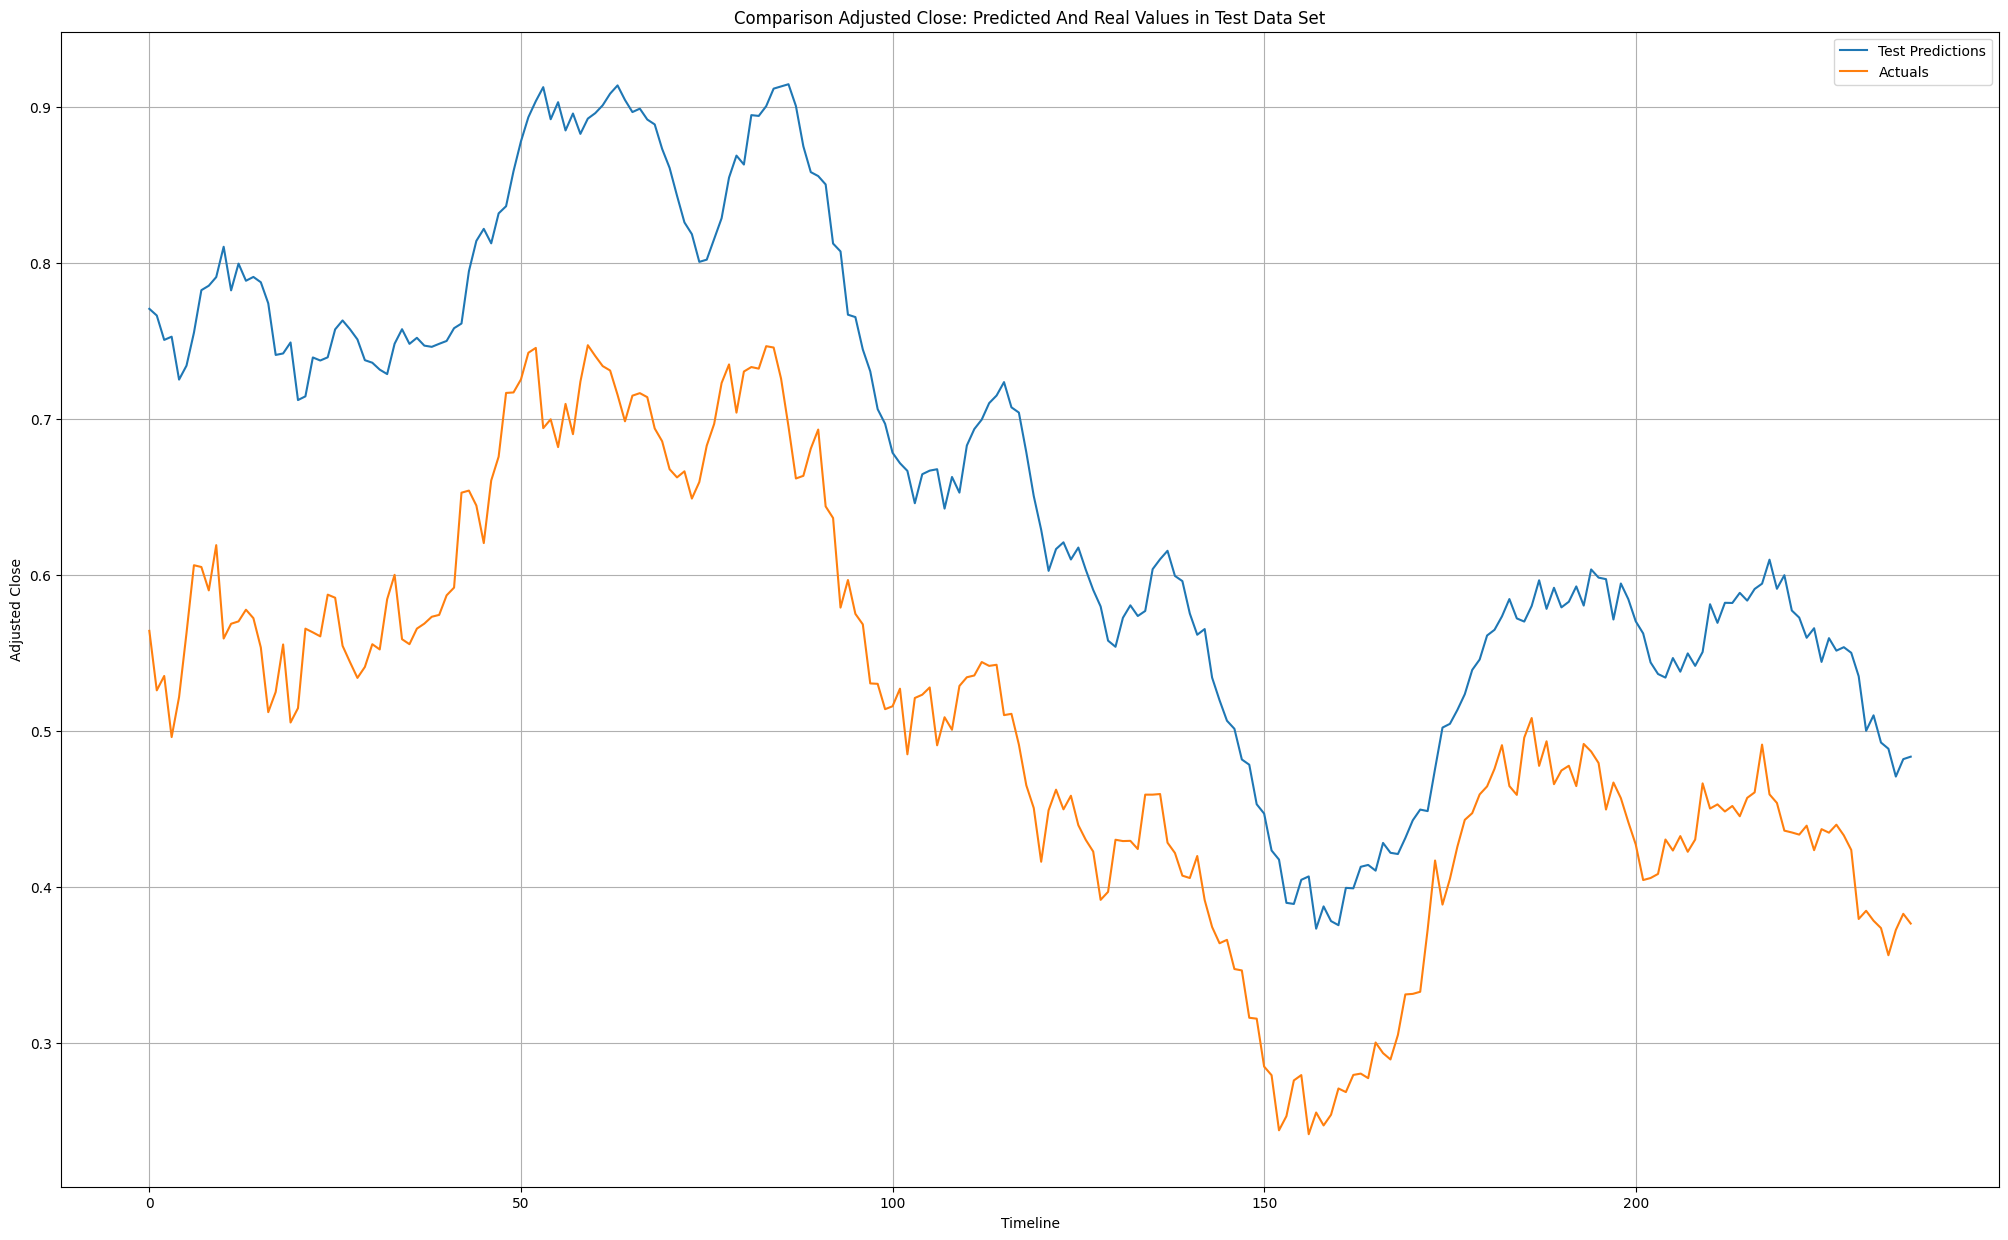

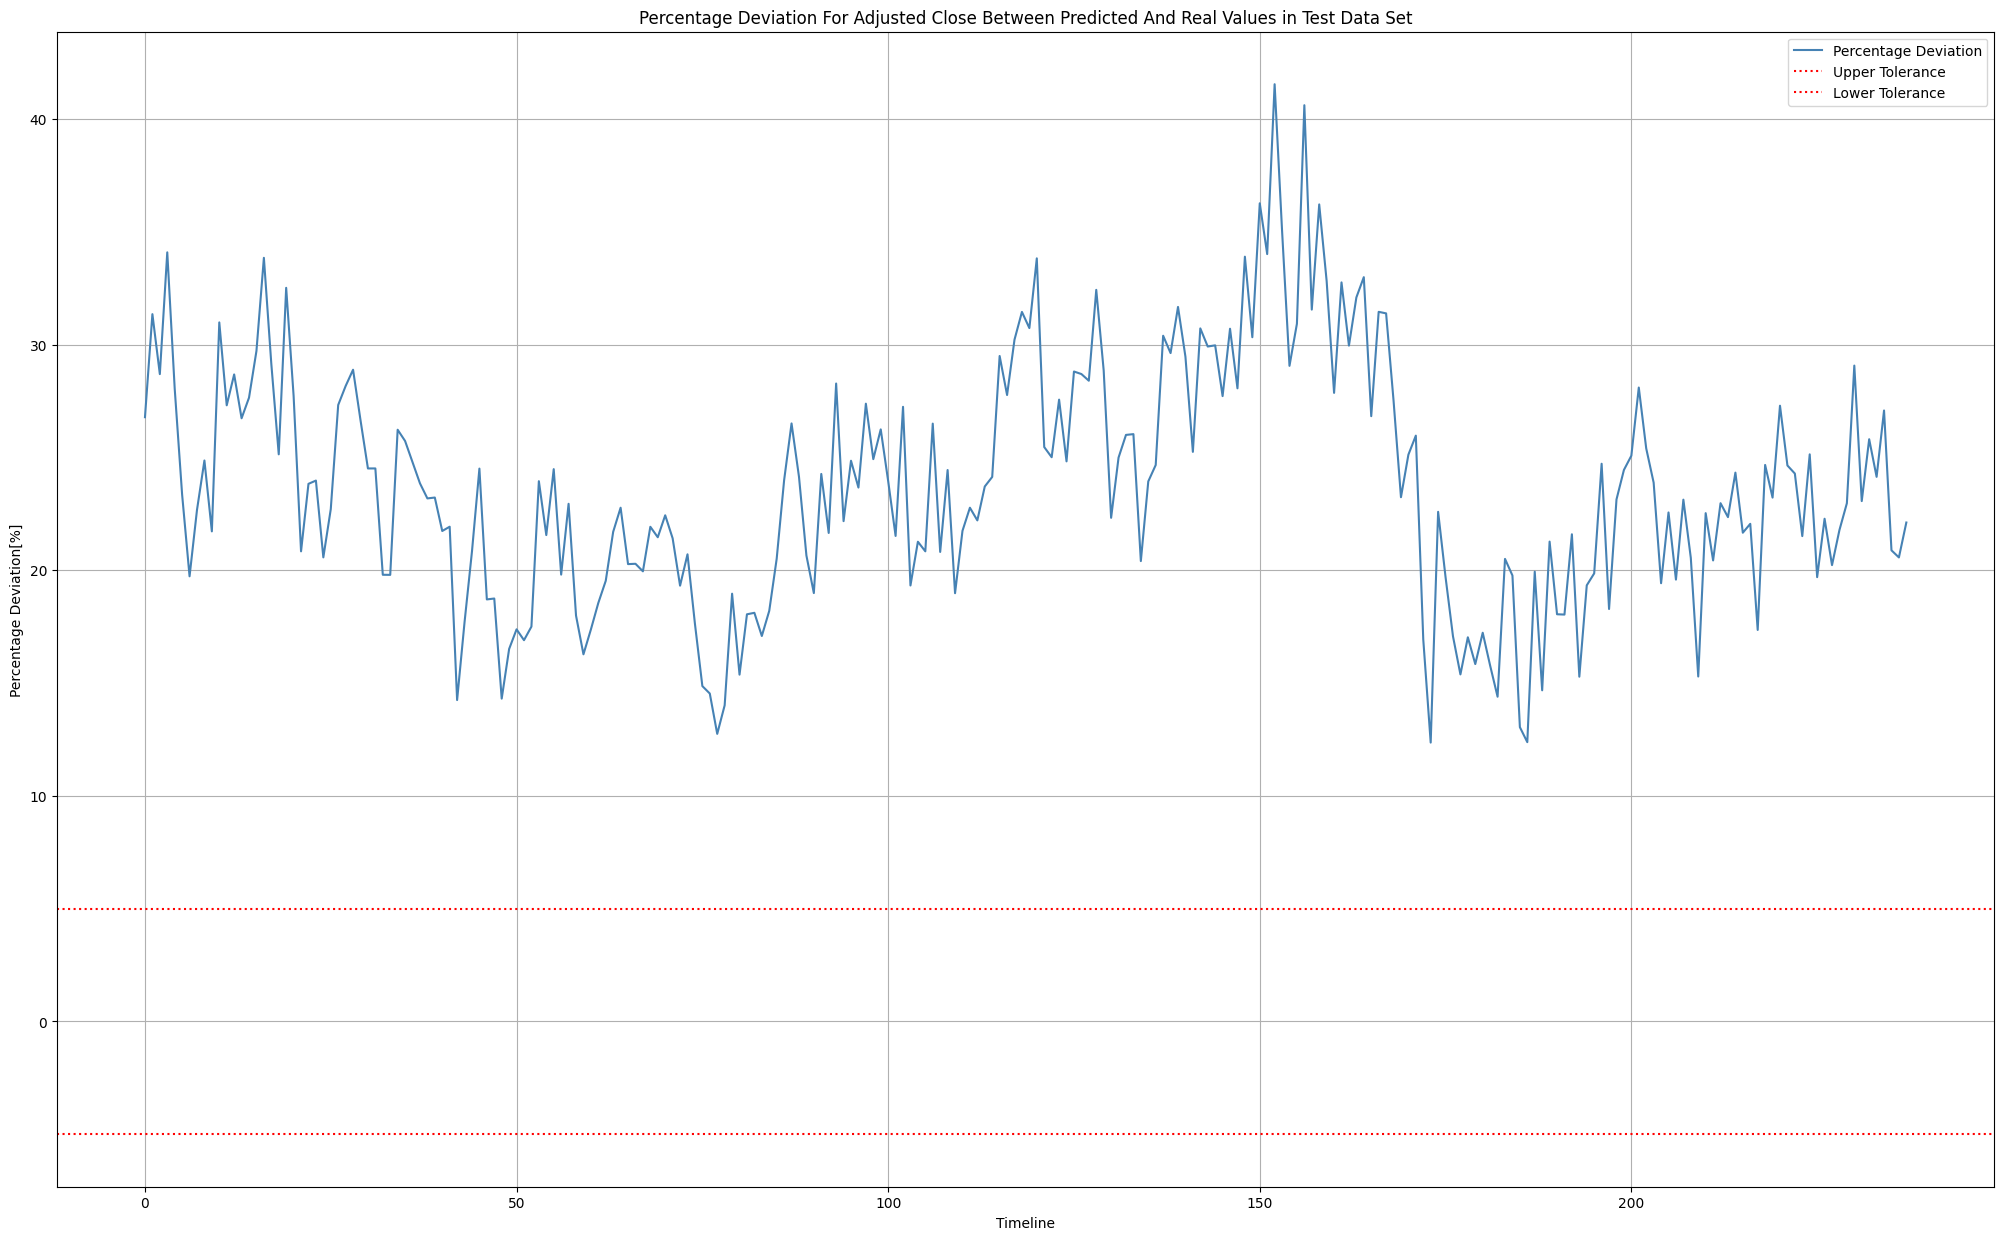

The mean for the percentage deviation in the test data is 23.74788143461277.
The MSE for the test data is 0.005145355127751827.
The window size is 3
---------------------------------


In [347]:
plotting_results(best_models)

In [145]:
data = Xs_test['JNJ'][-1]

predictions_list = []

for i in range(1, 29):  # Wiederholen Sie den Vorgang 10 Mal, um Vorhersagen für die nächsten 10 Zeitschritte zu erhalten
    
    print(i)
    prediction = model1.predict(np.array(data).reshape(1, 10, 17))  # Das Modell erwartet eine Eingabeform von (1, 10, 17)
    predictions_list.append(prediction)
    data = np.vstack((data[1:], prediction))

1
1/1 [==============================] - 0s 14ms/step
2
1/1 [==============================] - 0s 11ms/step
3
1/1 [==============================] - 0s 12ms/step
4
1/1 [==============================] - 0s 12ms/step
5
1/1 [==============================] - 0s 12ms/step
6
1/1 [==============================] - 0s 11ms/step
7
1/1 [==============================] - 0s 11ms/step
8
1/1 [==============================] - 0s 12ms/step
9
1/1 [==============================] - 0s 12ms/step
10
1/1 [==============================] - 0s 12ms/step
11
1/1 [==============================] - 0s 12ms/step
12
1/1 [==============================] - 0s 11ms/step
13
1/1 [==============================] - 0s 12ms/step
14
1/1 [==============================] - 0s 12ms/step
15
1/1 [==============================] - 0s 12ms/step
16
1/1 [==============================] - 0s 11ms/step
17
1/1 [==============================] - 0s 12ms/step
18
1/1 [==============================] - 0s 11ms/step
19
1/1 [===========

In [148]:
a = [arr[-1] for arr in data]
b = [arr[-1] for arr in Xs_test['JNJ'][-1]]

In [150]:
a

[0.7531004548072815,
 0.7520443797111511,
 0.7510243058204651,
 0.7500399351119995,
 0.7490900754928589,
 0.748173177242279,
 0.747286319732666,
 0.7464272379875183,
 0.7455933094024658,
 0.7447816133499146]

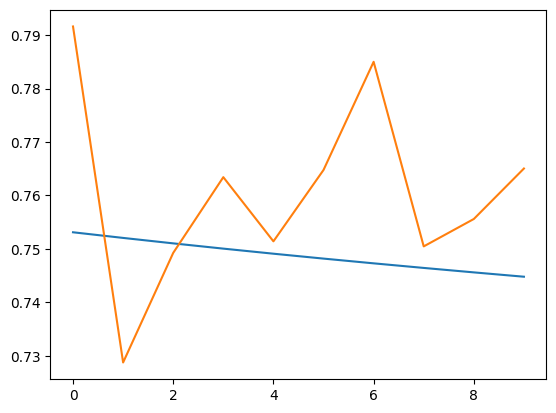

In [151]:
plt.plot(a)
plt.plot(b)

In [147]:
len(data)

10

Neuer Plan:
- Jupyter Notebooks fertig machen
- Klassich Daten (nur Stock Namen) eingeben
    - Daten in DB speichern
    - Neues Programm: Visualisierung in einem Neuen Fenster, wenn der Kunde es wünscht
    - Neues Programm: starten für Prediction
        - Daten laden und feature engineering durchführen
        - LTSM trainieren (50 Epochen, inklusiere finden des besten window-fensters)
        - Zukunftswerte predicten: 7, 14, 28 Tage
        - Visualisierung von Status Quo zu Prediction mit Empfehlung
               - Kunden Visualisierung:
                     - Testdaten zeigen in einer Farbe
                     - Zukunftswerte (Kursentwicklung) in einer anderen Farbe
                     - Empfehlung schreiben:
                     - Ist der Wert größer nach 28 Tage: Behalten
                     - kleiner: verkaufen